<a href="https://colab.research.google.com/github/pelandrun/acamica/blob/main/proyecto_acamica_03v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### Imports y Funciones

#### Imports

In [ ]:
# !pip install scikit-surprise
# !pip install language-detector

In [ ]:
# from surprise import Dataset
# from surprise import Reader
# from surprise.model_selection import train_test_split
# from surprise import SVD
from time import time 
import gzip
import pandas as pd
import sys
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import datetime
# from language_detector import detect_language
random_state=42
verbose = 3
np.random.seed(seed=random_state) 

#### Funciones

##### Funcion drop outliers

In [ ]:
def dropOutlier(data, mask, cleancol):
# Elimina los outliers por el metodo de 3 sigmas, devuelve el dataset
# data: es el dataset
# mask, para restringir dataset
# clancol: es la comumna de la que queremos limpiar los outliers
  """Elimina los outliers por el metodo de 3 sigmas, devuelve el dataset
  
  Parameters
  ----------
  data : padandas Datafreae
  mask : pandasmask
      mascara
  cleancol: str
      Columna a tratar
  """
  meanval = data[mask][cleancol].mean()
  std = data[mask][cleancol].std()
  min = meanval - 3*std
  max = meanval + 3*std
  print(std,min,max)
  mask1 = np.logical_or(data[cleancol] < min, data[cleancol] > max)
  return data.drop(data[mask & mask1].index)

In [ ]:

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [ ]:
basepath="/content/drive/My Drive/Colab Notebooks/acamica_p03/"
datapath=basepath+"Datasets/"
steam_reviews_file=datapath+"steam_reviews.json.gz"
steam_games_file=datapath+"steam_games.json.gz"
steam_games_parquet=datapath+"steam_games.parquet"
steam_reviews_parquet=datapath+"steam_reviews.parquet"

In [ ]:
gc.enable()

### Carga Datasets

#### **Reviews**

In [ ]:
a=1
def test():
  a=10
a

1

In [ ]:
def load_reviews_from_gzip():  
  contador = 0
  data_reviews = []
  # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
  # abrira uno de cada tres, y asi.
  n = 10
  for l in parse(steam_reviews_file):
      if contador%100000 == 0:
        print(str(contador)+" ", end='')
      if contador%n == 0:
          data_reviews.append(l)
      else:
          pass
      contador += 1
  return data_reviews


In [ ]:
%%time
if os.path.isfile(steam_reviews_parquet):
  print ("Cargo dataset cache")
  data_reviews=pd.read_parquet(steam_reviews_parquet)
else:
  print('Salvo en cache')
  data_reviews=load_reviews_from_gzip()
  data_reviews = pd.DataFrame(data_reviews)
  data_reviews.to_parquet(steam_reviews_parquet)

Cargo dataset cache
CPU times: user 4.85 s, sys: 9.86 s, total: 14.7 s
Wall time: 17.3 s


#### **Games**

In [ ]:
%%time
data_games = []
for l in parse(steam_games_file):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

CPU times: user 2.38 s, sys: 20.5 ms, total: 2.4 s
Wall time: 3.34 s


In [ ]:
data_games.shape

(32135, 16)

In [ ]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

In [ ]:
pd.unique(data_games.sentiment)

array([nan, 'Mostly Positive', 'Mixed', '1 user reviews',
       '3 user reviews', '8 user reviews', 'Very Positive',
       'Overwhelmingly Positive', '6 user reviews', '5 user reviews',
       '2 user reviews', 'Very Negative', 'Positive', 'Mostly Negative',
       '9 user reviews', 'Negative', '4 user reviews', '7 user reviews',
       'Overwhelmingly Negative'], dtype=object)

In [ ]:
len(pd.unique(data_reviews.product_id))

12665

In [ ]:
# tmp=pd.merge(data_reviews,data_games,left_on='product_id',right_on='id', how='left')

In [ ]:
# tmp.shape

In [ ]:
# tmp.isna().sum()

In [ ]:
# pd.unique(tmp.sentiment)

In [ ]:
# tmp.sentiment.value_counts()

In [ ]:
# tmp[tmp.sentiment=='1 user reviews']

In [ ]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [ ]:
data_games[data_games.id == '35140']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31617,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,35140,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [ ]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


# EDA

### Un vistazo a reviews

In [ ]:
data_reviews.head(200)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,None,None,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,None,None,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,None,None,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
195,ThorPoint,43.6,50.0,452570,4,2017-12-02,This has just hit my favourite game of the yea...,False,8,76561198185146037,None,NaN
196,Bibbly,1.4,270.0,350280,3,2017-12-26,I cannot recommend a game that asks 9 to 15 mi...,False,10,None,None,NaN
197,FireBolt,58.1,69.0,271590,0,2018-01-04,modders in (almost) every session found one in...,False,2,76561198218134795,None,NaN
198,rosswmrice,24.5,379.0,452570,6,2017-12-01,I backed this game on kickstarted and was so e...,False,8,76561198055510217,Product received for free,NaN


Lo primero para destacar es que no contamos con un diccionario de datos, algunas columnas tienen nombres que son autodescriptivos y otras no tanto. |

* username: parace ser el id por con el que podemos identificar un usuario y atribuirle un review.
* hours: la cantidad de horas que el usuario jugó este juego/producto.
* products: ??? podría ser la cantidad de juegos propiedad de este usuario pero tengo mis dudas.
* product_id: identifica el juego o producto.
* page_order: ?
* date: fecha de la revisión
* text: la revisión en forma textual descriptiva.
* early_access: podría indicar varias cosas.
  1. El usuario tuvo acceso al producto antes de la fecha de lanzamiento.
  2. El usuario fue de los primeros en acceder al juego.
  Si bien ambas opciones son similares, podrían denotar espectativa del usuario por el producto, no son lo mismo.

* page: ????
* user_id: tipicamente uno esperaria el identificador numerioc del username, pero en este caso no parece ser así.
* compensation: parece indicar que el producto llegó al usuario sin costo, compensando un reclamo.
* found_funny: a primera vista uno podriá suponer que se refiere al juego pero parece que se refiere a que el contenido de "text" es gracioso o divertido.


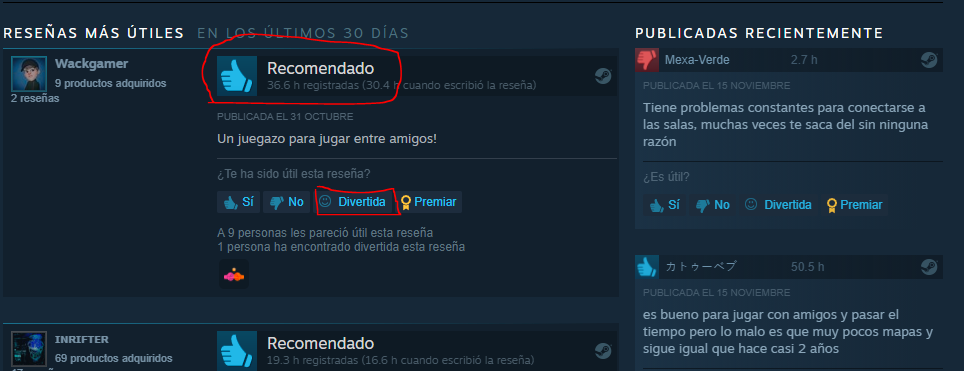

Veamos primero como es el resumen de valoraciones de un juego.

Se puede distingir claramente si la reseña recomienda o no el juego, este dato no esta representado en el dataset. 

#### Valores peridos.

#### Frecuencia

In [ ]:
freqcuencia_repetidos=data_reviews.astype('object').describe().transpose()

In [ ]:
freqcuencia_repetidos

,count,unique,top,freq
username,779307,540341,123,213
hours,776670,21762,0.2,11310
products,777741,3926,9,4771
product_id,779307,12665,440,18373
page_order,779307,10,1,87582
date,779307,2617,2016-11-23,6405
text,779307,718779,,1837
early_access,779307,2,False,671616
page,779307,18368,1,12996
user_id,317340,262058,76561198011965365,114


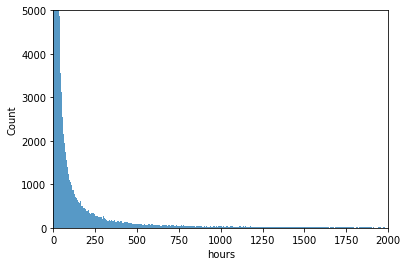

In [ ]:
chart = sns.histplot(data_reviews.hours)
chart.set_ylim(0,5000)
chart.set_xlim(0,2000)
plt.show()


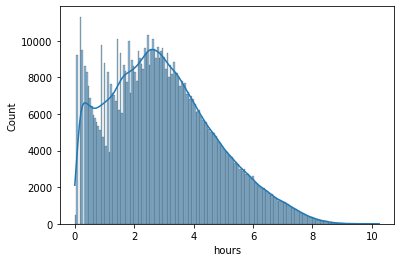

In [ ]:
chart = sns.histplot(np.log1p(data_reviews.hours), kde=True)

La distribución logaritmica de las horas jugadas muestra unos picos, la verdad que no entiendo a que se deben, podría ser comportamiento o quiza la forma en que crawelearon los datos.

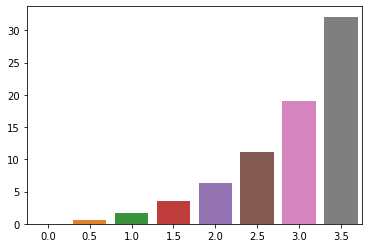

In [ ]:
test=np.arange(0,4,.5)
sns.barplot(y=np.exp(test) - 1, x=test)

In [ ]:
data_reviews.shape

(779307, 12)

In [ ]:
data_reviews.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hours,776670.0,111.843832,390.145376,0.0,4.0,15.3,59.6,28164.0
products,777741.0,236.993936,486.034479,1.0,45.0,110.0,246.0,13540.0
page_order,779307.0,4.417743,2.897848,0.0,2.0,4.0,7.0,9.0
page,779307.0,893.581355,1928.272966,1.0,53.0,238.0,829.0,18371.0
found_funny,120164.0,7.713125,72.465816,1.0,1.0,1.0,3.0,6524.0


Se nota una distribución anormal al observar los valores de media y moda, sin embargo existe información que no podemos detectad aqui, por ejemplo, cuantos revies tiene un usuario, cual es su media, lo mismo ocurre con el total de horas jugadas.
Vamos a generear esos features y para ver que encontramos.

#### Generando variables total_hours y total_reviews

In [ ]:
data_reviews_grpbtusername=data_reviews.groupby(by=['username'])
data_reviews['total_hours']=data_reviews_grpbtusername.hours.transform('sum')
data_reviews['total_reviews']=data_reviews_grpbtusername.username.transform('count')

Repetimo el describe.

In [ ]:
data_reviews.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hours,776670.0,111.843832,390.145376,0.0,4.0,15.3,59.6,28164.0
products,777741.0,236.993936,486.034479,1.0,45.0,110.0,246.0,13540.0
page_order,779307.0,4.417743,2.897848,0.0,2.0,4.0,7.0,9.0
page,779307.0,893.581355,1928.272966,1.0,53.0,238.0,829.0,18371.0
found_funny,120164.0,7.713125,72.465816,1.0,1.0,1.0,3.0,6524.0
total_hours,779307.0,415.054356,3473.515659,0.0,10.4,43.3,184.4,196235.4
total_reviews,779307.0,4.014786,10.679519,1.0,1.0,1.0,3.0,213.0


#### Revisamos usuarios

Text(0.5, 1.0, 'Top 10 de usuarios con mas reviews')

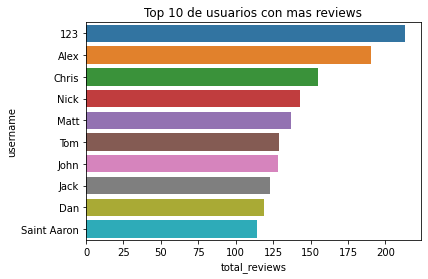

In [ ]:
users_review_count=pd.DataFrame(data_reviews.groupby(by=['username']).username.count().rename('total_reviews')).reset_index().sort_values(['total_reviews'], ascending=False)
chart = sns.barplot(x='total_reviews', y='username',data=users_review_count.head(10))
chart.set_title('Top 10 de usuarios con mas reviews')


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


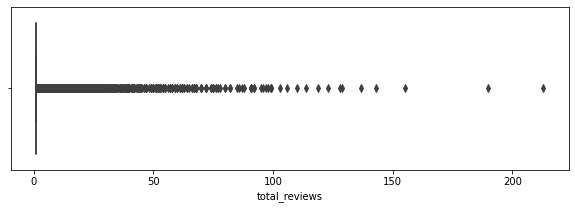

In [ ]:
plt.figure(figsize=(10,3))
sns.boxplot('total_reviews',data=users_review_count)
plt.show()

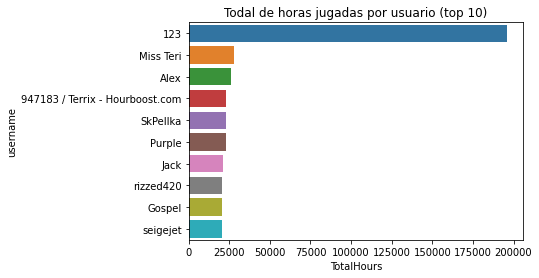

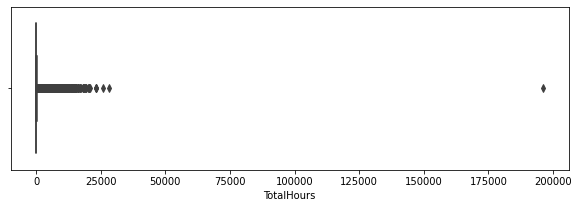

In [ ]:
def users_total_hours_f():
  users_total_hours=pd.DataFrame(data_reviews.groupby(by=['username']).hours.sum().rename('TotalHours')).reset_index().sort_values(['TotalHours'], ascending=False)
  chart = sns.barplot(x='TotalHours', y='username', data=users_total_hours.head(10))
  chart.set_title('Todal de horas jugadas por usuario (top 10)')
  plt.show()
users_total_hours_f()
users_total_hours=pd.DataFrame(data_reviews.groupby(by=['username']).hours.sum().rename('TotalHours')).reset_index().sort_values(['TotalHours'], ascending=False)
plt.figure(figsize=(10,3))
sns.boxplot(x='TotalHours',data=users_total_hours)
plt.show()

Que es esto "947183 / Terrix - Hourboost.com	" mmmm, investigando el dominio descubrimos que vende un servicio que se conecta a los juegos para sumar horas. Seguramente el target son desarrolladores que quieren posisionar sus productos.

Vamos a eliminar utilizando la regla de los tres sigmnas los usuarios cuya cantidad de horas jugadas y reviews se enuentre por fuera de la regla.

#### Quien es Alex?

Alex, lo encontramos ahí, en el top 10 de más horas jugadas y mas reviews realizados. Examinemos un poco

In [ ]:
data_alex=data_reviews[data_reviews.username=='Alex'].sort_values(by=['user_id'])
data_alex

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny,total_hours,total_reviews
454970,Alex,132.2,10.0,531640,3,2017-11-28,Awsome game tons of fun,True,11,76561197964193414,None,NaN,25884.5,190
678658,Alex,159.8,56.0,427520,7,2017-04-07,"Addictive, factory building game with a great ...",True,676,76561197965536831,None,NaN,25884.5,190
506286,Alex,5.1,62.0,386900,1,2015-10-04,Really fun and challenging puzzle game.,False,7,76561197972750200,None,NaN,25884.5,190
19462,Alex,1.6,140.0,200710,6,2015-06-18,A parody of diablo,False,450,76561197973126243,None,NaN,25884.5,190
284219,Alex,2.4,30.0,393380,4,2017-07-19,"Freezes often, to the point of locking out tas...",True,293,76561197977762361,None,NaN,25884.5,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751386,Alex,66.1,239.0,518790,8,2017-10-04,theHunter: Call of the Wild - Review after 30 ...,False,108,None,None,NaN,25884.5,190
764481,Alex,89.2,126.0,391540,2,2016-06-18,I got this game a good while back but I felt t...,False,2616,None,None,NaN,25884.5,190
766865,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4233,None,None,NaN,25884.5,190
766887,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4238,None,None,NaN,25884.5,190


Podemos observar que existen 190 entradas para el usuario Alex.

In [ ]:
print('Alex tiene '+str(len(data_alex.user_id.value_counts().index))+' user_id diferentes')


Alex tiene 57 user_id diferentes


In [ ]:
pd.DataFrame({
    'product_id': data_alex.product_id.value_counts().index,
    'count':data_alex.product_id.value_counts()
})

,product_id,count
440,440,5
377160,377160,4
4000,4000,4
252490,252490,4
355840,355840,3
...,...,...
219890,219890,1
32380,32380,1
55230,55230,1
576030,576030,1


Alex realizó mas de una review para un mismo producto, algo que no se puede realizar.

Evidentemente Alex no es un usuario, Alex es muchos usuarios diferentes. No podemos fiarnos del **username** como identificador del usuario y tenemos demasiado s NaN para el atributo **user_id**.

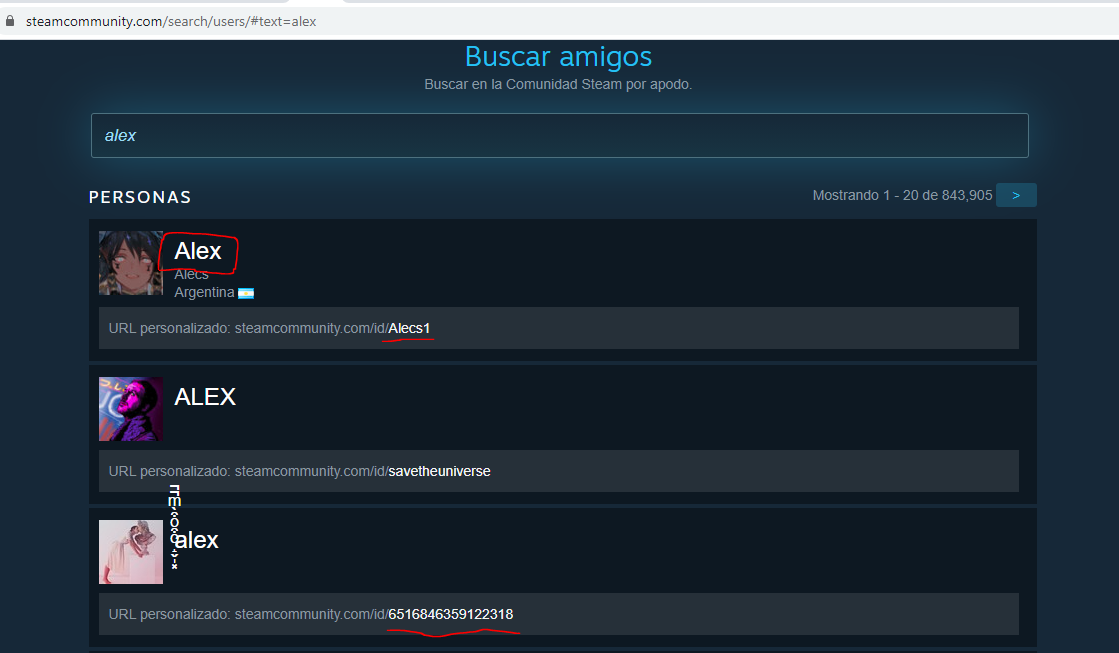

La captura revela que existen muchos Alex, algunos identificados por **id**, que es un identificador alfanumérico y otras identificadas por **profile** que a primera vista es semejante al atributo **user_id** de nuestro dataset.

Busquemos a los dos primeros **user_id** del dataset.

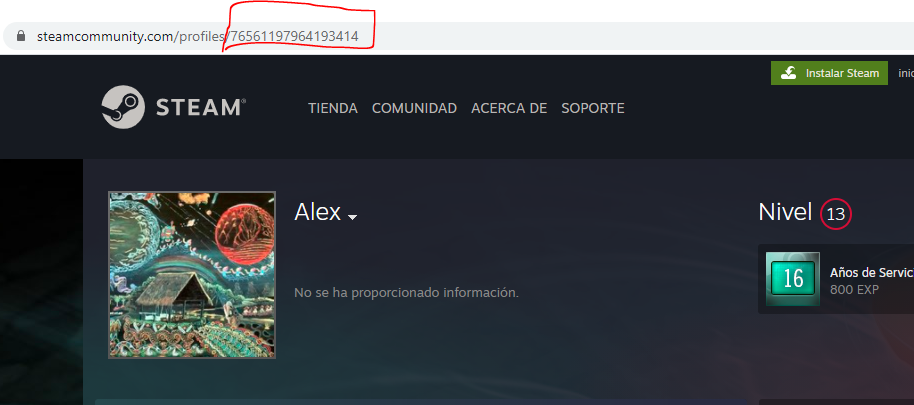

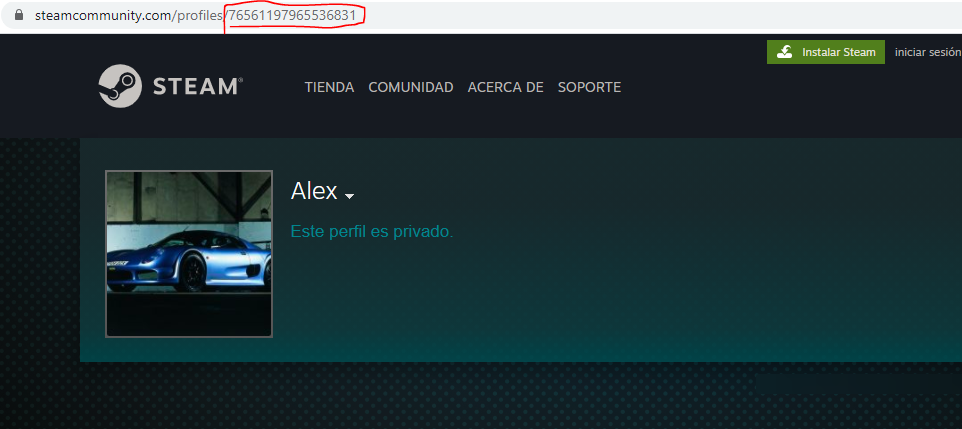

Con esta premisa confirmada, la primer transformación que vamos a realizar es reemplazar username por user_id en aquellas instancias con valores user_id  distintos de NaN.

#### Asignamos user_id a username cuando cuando user_id!=NaN

user_reset es una bandera que indica que el se remplazó el **username** por el **user_id**.

In [ ]:
alex_mask=data_reviews.username=='Alex'

In [ ]:
mask=(~data_alex.user_id.isna())
data_alex.loc[mask,'username']=data_alex[mask]['user_id']
data_alex['user_reset']=0;
data_alex.loc[mask,'user_reset']=1 

Chequeamos visualmente, las filas etiquetadas como username==Alex.

In [ ]:
data_alex

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny,total_hours,total_reviews,user_reset
454970,76561197964193414,132.2,10.0,531640,3,2017-11-28,Awsome game tons of fun,True,11,76561197964193414,None,NaN,25884.5,190,1
678658,76561197965536831,159.8,56.0,427520,7,2017-04-07,"Addictive, factory building game with a great ...",True,676,76561197965536831,None,NaN,25884.5,190,1
506286,76561197972750200,5.1,62.0,386900,1,2015-10-04,Really fun and challenging puzzle game.,False,7,76561197972750200,None,NaN,25884.5,190,1
19462,76561197973126243,1.6,140.0,200710,6,2015-06-18,A parody of diablo,False,450,76561197973126243,None,NaN,25884.5,190,1
284219,76561197977762361,2.4,30.0,393380,4,2017-07-19,"Freezes often, to the point of locking out tas...",True,293,76561197977762361,None,NaN,25884.5,190,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751386,Alex,66.1,239.0,518790,8,2017-10-04,theHunter: Call of the Wild - Review after 30 ...,False,108,None,None,NaN,25884.5,190,0
764481,Alex,89.2,126.0,391540,2,2016-06-18,I got this game a good while back but I felt t...,False,2616,None,None,NaN,25884.5,190,0
766865,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4233,None,None,NaN,25884.5,190,0
766887,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4238,None,None,NaN,25884.5,190,0


Parece que aisgnó correctamente.

#### Ahora podemos eliminar la columna user_id

In [ ]:
data_alex.drop(columns=['user_id'],inplace=True)

Veamos ahora como quedo nuestro nuevo Alex, 

In [ ]:
data_alex[data_alex.username=='Alex']

,username,hours,products,product_id,page_order,date,text,early_access,page,compensation,found_funny,total_hours,total_reviews,user_reset
1571,Alex,1.8,86.0,271860,1,2015-05-30,Давально интиресная игра,False,11,None,1.0,25884.5,190,0
14130,Alex,7.8,174.0,225080,5,2017-05-19,"Glad I took the time to place this. Sure, the ...",False,137,None,NaN,25884.5,190,0
16914,Alex,257.8,44.0,271590,0,2017-07-11,It's a very bad game for those who want to pla...,False,1766,None,NaN,25884.5,190,0
30275,Alex,24.0,25.0,488790,5,2017-11-26,"pretty good game , except the u play system",False,44,None,NaN,25884.5,190,0
51124,Alex,516.1,163.0,48700,2,2016-01-09,"Used to be nice in the old days, but not anymo...",False,1498,None,NaN,25884.5,190,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751386,Alex,66.1,239.0,518790,8,2017-10-04,theHunter: Call of the Wild - Review after 30 ...,False,108,None,NaN,25884.5,190,0
764481,Alex,89.2,126.0,391540,2,2016-06-18,I got this game a good while back but I felt t...,False,2616,None,NaN,25884.5,190,0
766865,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4233,None,NaN,25884.5,190,0
766887,Alex,60.1,384.0,252490,3,2016-07-12,I don't play many of these types of survival g...,True,4238,None,NaN,25884.5,190,0


La situación mejoró, Alex tenia 190 reviews, ahora tiene 120, pero aun podemos detectar algunas inconsistencias algunas de ellas indican que estás 120 entradas pertenecen a distintos Alex,.

Las banderas rojas son:
1. Filas repetidas.
2. Hay reseñas en distintos idiomas 
3. Cantidad de productos diferentes entre reseñas.

Bueno, las filas repetidas con seguridad deben eliminarse. Las otras banderas rojas son más bien amarillas, podría darse que el usuario adquiriese más productos entre reseña y reseña, y que escriba algunas en su lengua materna y otras en inglés.
Vamos por pasos.

#### 1 Eliminamos duplicados

Eliminar los duplicados tiene un pequeño truco, como se efectuaron varios crawls, la reseña duplicada, en cada aparición aparece en una **page** (número de orden de la página) y **pager_order** (número de orden dentro de la página). Para poder detectar los duplicados obviamos dichas columnas al crear la máscara.

In [ ]:
print('Cantidad de duplicados a eliminar')
print(data_alex[data_alex.drop(columns=['page','page_order']).duplicated(keep='first')].shape[0])
data_alex=data_alex[~data_alex.drop(columns=['page','page_order']).duplicated(keep='first')]

Cantidad de duplicados a eliminar
1


In [ ]:
data_alex[data_alex.username=='Alex'].sort_values(by=['products']).shape

(119, 14)

Alex pasó de 119 a 120, por lo menos una Alex era dueño de una reseña repetida.

#### 2 Reseñas en diferentes idiomas.

Sobre el supuesto que un usuario escribe reseñas solo en un idioma, podrias detectar que un un username esta repetido con esta premisa.

Si bien podemos importar alguna biblioteca y detectar de forma más o menos sencilla el idioma, es algo que va a tomar su tiempo para un dataset tan grande. Vamos a tratar de evitar utilizar este método... por ahora.

#### 3 Distinta cantidad de productos para un mismo username

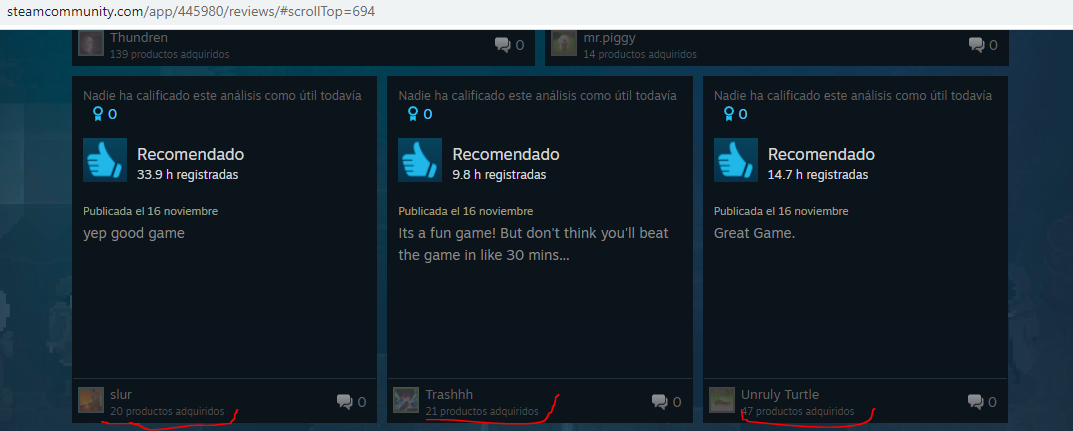

Esta captura de reseñas de un juego cualquiera en steam, nos muestra que la cantidad de productos del autor de la reseña es del momento en que se realizó el crowl y no del momento en que se realizó la reseña.
Si bien no sabemos la duración de la ventana de tiempo en la que se realizó el recabado del dataset, podemos esperar que para la mayoría de los usuarios, la variable **products** se mantenga igual en todos sus reviews, y que no podemos encontrar un usuario propietario de distinta cantidad de productos. Aún siendo esto cierto, también podríamos encontrarnos con usuarios distintos. con mismo **username** y que  tengan la misma cantidad de productos, haciendolos imposibles de diferenciar.

In [ ]:
# data_alex=data_reviews[data_reviews.username=='Alex']
# data_alex.shape

Recordemos que existen 119 entradas para Alex.

Revismos las entradas ordenadas por cantidad de productos.


In [ ]:
data_alex[data_alex.user_reset==0].sort_values(by=['products'])

,username,hours,products,product_id,page_order,date,text,early_access,page,compensation,found_funny,total_hours,total_reviews,user_reset
442164,Alex,1.7,3.0,434570,0,2016-08-01,Great game for vegetarians!,False,607,None,4.0,25884.5,190,0
484770,Alex,12.0,4.0,204300,1,2015-10-16,So many aylas that my feet hurt,False,456,None,NaN,25884.5,190,0
103569,Alex,0.1,9.0,712770,2,2017-11-02,The Hyper Carries come through with yet anothe...,False,2,None,NaN,25884.5,190,0
742333,Alex,50.6,11.0,252490,8,2017-08-18,Very Good Game!,True,1228,None,NaN,25884.5,190,0
145534,Alex,84.6,11.0,4000,2,2017-07-07,A Very Good Game,False,1618,None,NaN,25884.5,190,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397824,Alex,3.6,2313.0,474050,4,2017-06-03,Inexpensive and I had fun playing it. For this...,False,1,None,NaN,25884.5,190,0
323749,Alex,4.9,2313.0,300380,4,2015-10-12,"Amazing game, I love it!",True,161,None,1.0,25884.5,190,0
282120,Alex,14.8,2313.0,244870,9,2014-08-20,"I enjoy platformers, but none is more brutal y...",False,80,None,NaN,25884.5,190,0
396930,Alex,5.4,2313.0,338710,3,2015-03-31,"I like to play chess quite a lot, but never in...",False,7,None,1.0,25884.5,190,0


Pareciera que podemos identificar mas o menos univocamente a un "Alex" en particular, concatenando **username**+**products**.

Exploramos el concepto.

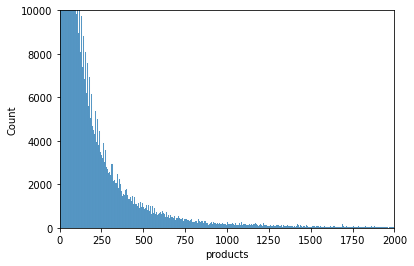

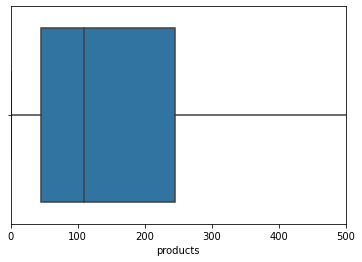

In [ ]:
chart = sns.histplot(data_reviews.products)
chart.set_xlim(0,2000)
chart.set_ylim(0,10000)
plt.show()
chart = sns.boxplot(x='products',data=data_reviews)
chart.set_xlim(0,500)
plt.show()

Como comentamos antes, con el método de concatenar **username**+**products** existe un dominio de colisión importante,sobre todo para los "Alex" con pocos productos donde se concentran la cantidad de usuarios.

En los gráficos anteriores podemos ver que el 50% de los usuarios tienen ~100 o menos juegos.

Sin embargo este parece ser el mejor acercamiento para identificar las entradas del dataset a un usuario univocamente.

In [ ]:
new_data_alex=data_alex[data_alex.user_reset==0].copy()
new_data_alex.loc[:,'username']
new_data_alex['newusername']=data_alex.username+data_alex.products.astype(str)
pd.DataFrame(new_data_alex.newusername.value_counts())

,newusername
Alex2313.0,5
Alex115.0,4
Alex283.0,4
Alex384.0,3
Alex257.0,3
...,...
Alex4.0,1
Alex265.0,1
Alex288.0,1
Alex139.0,1


Ahora tenemos 84 identificados 84 Alex distintos para 120 reviews. 

In [ ]:
data_alex[(data_alex.products == 2313.0)].shape

(5, 14)

Observemos a Alex2313.0, tiene 5 reseñas. Sabemos que inicialmente cargamos el 10% del dataset. Es decir que, suponiendo que el dataset completo contenga todas las reseñas de este alex deberíamos encontrar 50 reseñas aproximadamente.

Miremos su reseña para el producto 474050.

In [ ]:
data_alex[(data_alex.products == 2313.0) & (data_alex.product_id == "474050")]

,username,hours,products,product_id,page_order,date,text,early_access,page,compensation,found_funny,total_hours,total_reviews,user_reset
397824,Alex,3.6,2313.0,474050,4,2017-06-03,Inexpensive and I had fun playing it. For this...,False,1,None,NaN,25884.5,190,0


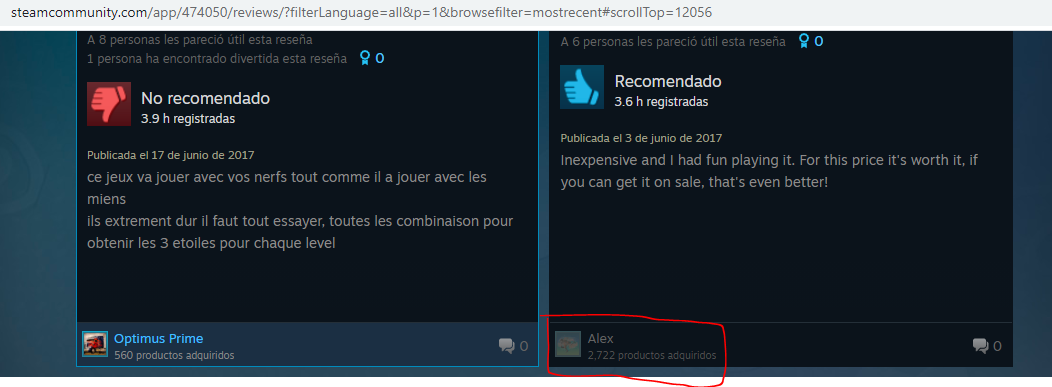

La reseña indica que ahora Alex tiene 2722 productos, pero comparando el texto podemos y el producto podemos estar seguros que esta reseña es la misma que tenemos en el dataset.

Veamos a este usuario en steam

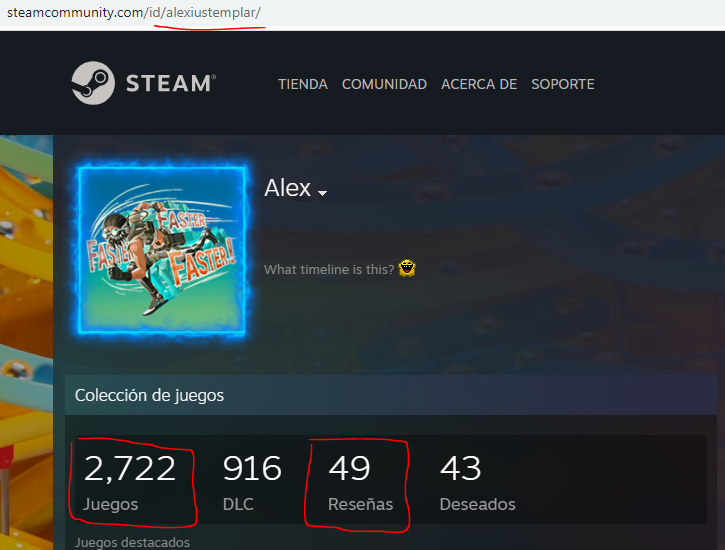

Bueno, calculamos que est Alex debia tener alrededor de 50 reseñas y no nos fue tan mal.

Test de hash

La idea detrás de esto es que puede existir un usuario ej Pedro10 y un usuario Pedro con 10 productos, concatenando username+products tendriamos el problema que convertiriamos Pedro a Pedro10, y Pedro10 ya existía por lo que existiria un solapamiento. Utilizando un hash de la variable **products** creariamos un identificador más "unívoco".

ej:

**username**+hash(**products**)=Pedro-5761304940058633631.


In [ ]:
test_hash=pd.DataFrame({'products':np.arange(1,10000)})
test_hash.products=test_hash.products.astype(str)
test_hash['hash']=test_hash.products.apply(lambda x: hash(x))
display(test_hash)
print('Repeticiones del valor hash:',test_hash.hash.value_counts().max())
print('No se repite')

,products,hash
0,1,5359511471489500891
1,2,-7821843747059837881
2,3,6927515315907603334
3,4,5987444080074903088
4,5,-3182538160686168575
...,...,...
9994,9995,-5839689092450140019
9995,9996,6846865464565724841
9996,9997,5852274336834439939
9997,9998,-911199775442958303


Repeticiones del valor hash: 1
No se repite


El concepto funciona, pero no vale la pena, la variable **products** se encuentran en formato float con 1 decimal y esto ya hace mucho más dificil la condición de colisión.

In [ ]:
del(data_alex)

#### Aplicando la transformación a todo el dataset.

Copiamos el dataset para poder realizar algunas comparaciones

In [ ]:
data_reviews_org=data_reviews.copy()

##### Remplazo username por user_id cuand user_id!=NaN

In [ ]:
### remplazo username por user_id
mask=(~data_reviews.user_id.isna())
data_reviews.loc[mask,'username']=data_reviews[mask]['user_id']
data_reviews['user_reset']=0;
data_reviews.loc[mask,'user_reset']=1 

##### Eliminamos duplicados

In [ ]:
### limino duplicados (ignoramos 'page','page_order' por que pueden estar repetidos)
print('Cantidad de duplicados a eliminar')
print(data_reviews[data_reviews.drop(columns=['page','page_order']).duplicated(keep='first')].shape[0])
data_reviews=data_reviews[~data_reviews.drop(columns=['page','page_order']).duplicated(keep='first')]

Cantidad de duplicados a eliminar
8684


##### Eliminando NaNs

Por lo menos algunos.

In [ ]:
data_reviews.isna().sum()

username              0
hours              2634
products           1553
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
user_id          456818
compensation     756172
found_funny      651679
total_hours           0
total_reviews         0
user_reset            0
dtype: int64

**products** eliminamos aquellas filas donde sen NaN y sean necesarios para concatenar con el usuario.

In [ ]:
data_reviews=data_reviews[~((data_reviews.user_reset==0) & (data_reviews.products.isna()))].copy()

In [ ]:
data_reviews.isna().sum()

username              0
hours              2634
products           1024
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
user_id          456289
compensation     755652
found_funny      651210
total_hours           0
total_reviews         0
user_reset            0
dtype: int64

**hours** vamos a completar los fatante por 0, para no perder las filas por ahora.

In [ ]:
data_reviews.loc[data_reviews.hours.isna(),'hours']=0

**found_funny**

Como el minimo es uno suponemos los NaN como 0

In [ ]:
data_reviews['found_funny'].min()

1.0

In [ ]:
data_reviews.loc[data_reviews.found_funny.isna(),'found_funny']=0

##### Concatenamos username con products cuando el username!=user_id

In [ ]:
mask=(data_reviews.user_reset==0)
newusername=data_reviews.loc[mask,'username']+'_'+data_reviews.loc[mask,'products'].astype(str)
data_reviews.loc[mask,'username']=newusername

In [ ]:
data_reviews.head(20)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny,total_hours,total_reviews,user_reset
0,Chaos Syren_41.0,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,None,None,0.0,0.1,1,0
1,Ariman1_1386.0,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,None,None,0.0,15.7,3,0
2,freakfantom_1706.0,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,None,None,0.0,0.1,1,0
3,76561198003030375,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,0.0,184.8,27,1
4,76561198353396844,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,None,0.0,8.2,1,1
5,Szudof_155.0,0.2,155.0,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",False,1,None,Product received for free,3.0,0.2,1,0
6,76561198113497324,2.7,264.0,35600,3,2017-04-15,I like the art style and the idea but what a b...,False,1,76561198113497324,None,0.0,21.8,3,1
7,76561198146674484,4.0,136.0,620900,3,2017-09-11,"Very, very good game. I love dungeon crawlers,...",False,1,76561198146674484,None,1.0,4.0,1,1
8,76561198080474371,34.8,3.0,1840,4,2018-01-04,WAY PAST COOL,False,1,76561198080474371,None,0.0,34.8,1,1
9,Devil Azite_548.0,0.1,548.0,671270,5,2017-07-09,Putting a hat on your head has disasterous rep...,False,1,None,Product received for free,1.0,0.1,1,0


Tipos de dato

Dropeo columnas que ya no aportan valor o estan desactualizadas.

In [ ]:
data_reviews.drop(columns=['user_reset','total_reviews','total_hours','user_id'],inplace=True)

In [ ]:
pd.unique(data_reviews.compensation)

array([None, 'Product received for free'], dtype=object)

In [ ]:
data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 770094 entries, 0 to 779306
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      770094 non-null  object 
 1   hours         770094 non-null  float64
 2   products      769070 non-null  float64
 3   product_id    770094 non-null  object 
 4   page_order    770094 non-null  int64  
 5   date          770094 non-null  object 
 6   text          770094 non-null  object 
 7   early_access  770094 non-null  bool   
 8   page          770094 non-null  int64  
 9   compensation  14442 non-null   object 
 10  found_funny   770094 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 65.4+ MB


In [ ]:
# data_reviews.product_id=data_reviews.product_id.astype(int)

#### Valores atípicos

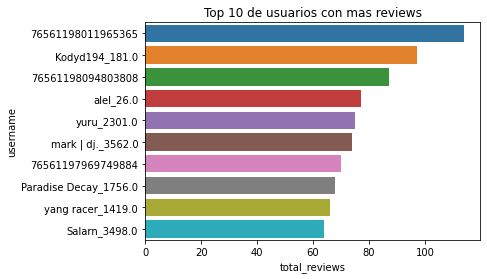

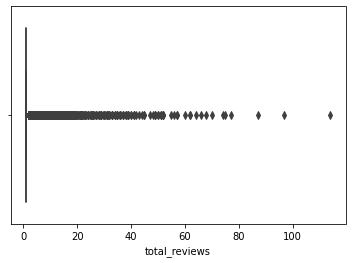

In [ ]:
users_review_count=pd.DataFrame(
    data_reviews.groupby(by=['username'])
    .username.count()
    .rename('total_reviews')
    ).reset_index().sort_values(['total_reviews'], ascending=False)

chart = sns.barplot(x='total_reviews', y='username',data=users_review_count.head(10))
chart.set_title('Top 10 de usuarios con mas reviews')
plt.show()
sns.boxplot(x='total_reviews',data=users_review_count)
del(users_review_count)

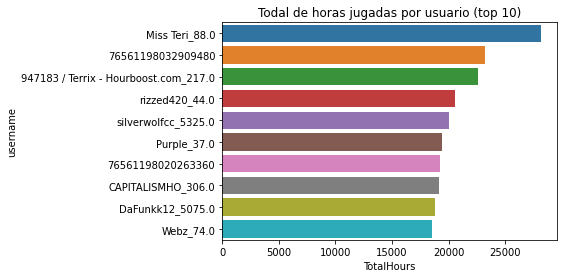

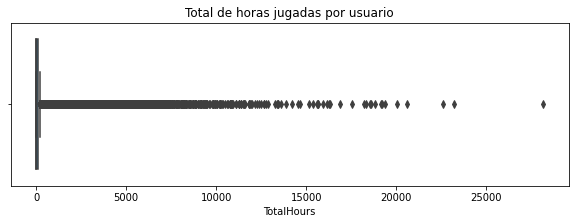

In [ ]:
users_total_hours_f()
users_total_hours=pd.DataFrame(data_reviews.groupby(by=['username']).hours.sum().rename('TotalHours')).reset_index().sort_values(['TotalHours'], ascending=False)
plt.figure(figsize=(10,3))
chart = sns.boxplot(x='TotalHours',data=users_total_hours)
chart.set_title('Total de horas jugadas por usuario')
plt.show()
del(users_total_hours)

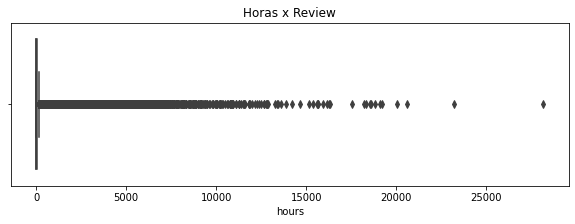

In [ ]:
plt.figure(figsize=(10,3))
chart = sns.boxplot(x='hours', data=data_reviews)
chart.set_title('Horas x Review')
plt.show()

Text(0.5, 1.0, 'Total de horas por producto')

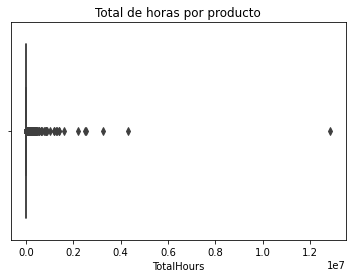

In [ ]:
product_total_hours=pd.DataFrame(data_reviews.groupby(by=['product_id']).hours.sum().rename('TotalHours')).reset_index().sort_values(['TotalHours'], ascending=False)
chart =sns.boxplot(x='TotalHours', data=product_total_hours)
chart.set_title('Total de horas por producto')

Se puede ver que casi todas las variables exploradas mustran valores atipicos cuya razón responde a diferentes indoles, algunas posibilidades y ejemplos serian

* Horas totales por produto: Estos valores atípicos se debe a que hay producto infinitamente mas populares que otros.
* hours: algunas persona jegan de forma mas apasionada que otras, algunas podrian deberse a bots.
* Horas totales por usuario: podrian ser que algunos usuarios llevan mas tiempo como miembros de la comunidad de steam que otros.

Estas son algunas de las razones por la que se encuentran valores atípicos, pero no encuentro sentido elimarlas, la unica razón seria eliminar usuarios genuinos de bots, por ejemplo u acotar el modelo a usuarios por determinado targe. Pero estos motivos escapan al objetivo de nuestra investigación.



#### Conclusiones de dataset data_reviews

Este dataset estaba muy sucio. Creo que el enfoque utilizado para la limpieza fue la mejor posible sin recurrir a fuentes de datos externas. Lamentablemente no tiene la calificación ni el sentimiento del usuario hacia el producto reseñado. Las horas jugadas podrían ser representativas de la afinidad, trataremos de profundizar más adelante. El juego abarca un periodo de tiempo de varios años, por lo que las estadísticas son históricas y pueden no mostrar las tendencias actuales.  

### Un vistazo a los Juegos

In [ ]:
data_games.head(10)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
5,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",NaN,http://steamcommunity.com/app/772540/reviews/?...,"[Single-player, Steam Achievements]",3.99,False,772540,Trickjump Games Ltd,Mixed,NaN
6,NaN,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Basic Pass,SNOW - All Access Basic Pass,http://store.steampowered.com/app/774276/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]",NaN,http://steamcommunity.com/app/774276/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",9.99,False,774276,Poppermost Productions,NaN,NaN
7,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Pro Pass,SNOW - All Access Pro Pass,http://store.steampowered.com/app/774277/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]",NaN,http://steamcommunity.com/app/774277/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",18.99,False,774277,Poppermost Productions,NaN,NaN
8,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports]",SNOW - All Access Legend Pass,SNOW - All Access Legend Pass,http://store.steampowered.com/app/774278/SNOW_...,2018-01-04,"[Free to Play, Indie, Simulation, Sports]",NaN,http://steamcommunity.com/app/774278/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",29.99,False,774278,Poppermost Productions,NaN,NaN
9,RewindApp,"[Casual, Indie, Racing, Simulation]",Race,Race,http://store.steampowered.com/app/768800/Race/,2018-01-04,"[Indie, Casual, Simulation, Racing]",NaN,http://steamcommunity.com/app/768800/reviews/?...,"[Single-player, Multi-player, Partial Controll...",NaN,False,768800,RewindApp,NaN,NaN


In [ ]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


In [ ]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

Descartamos los productos sin id

In [ ]:
data_games=data_games[~data_games.id.isna()]

In [ ]:
data_games.astype('object').describe().transpose()

,count,unique,top,freq
publisher,24082,8239,Ubisoft,385
genres,28851,883,[Action],1880
app_name,32132,32094,Soundtrack,3
title,30084,30054,Soundtrack,3
url,32133,32133,http://store.steampowered.com/app/338480/Redux...,1
release_date,30067,3582,2012-10-16,100
tags,31971,15395,"[Casual, Simulation]",1292
discount_price,224,82,22.66,35
reviews_url,32133,32132,http://steamcommunity.com/app/612880/reviews/?...,2
specs,31464,4649,[Single-player],2794


Id, app_name contiene duplicados, deshagamosnos de ese id duplicado.

In [ ]:
data_games=data_games[~data_games[['id']].duplicated(keep='first')]

Veamos ese título 'soundtrack'

In [ ]:
data_games[data_games.app_name=='Soundtrack']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
4863,NaN,"[Action, Indie]",Soundtrack,Soundtrack,http://store.steampowered.com/app/411110/Sound...,2015-11-30,"[Action, Indie]",NaN,http://steamcommunity.com/app/411110/reviews/?...,"[Single-player, Downloadable Content]",2.99,False,411110,Ink Stains Games,Positive,NaN
20351,Green Sawdust,[Indie],Soundtrack,Soundtrack,http://store.steampowered.com/app/561720/Sound...,2016-11-28,[Indie],NaN,http://steamcommunity.com/app/561720/reviews/?...,"[Single-player, Downloadable Content]",2.99,False,561720,Green Sawdust,NaN,NaN
28090,CI Games,"[Action, RPG]",Soundtrack,Soundtrack,http://store.steampowered.com/app/327270/Sound...,2014-10-28,"[Action, RPG]",NaN,http://steamcommunity.com/app/327270/reviews/?...,"[Single-player, Downloadable Content, Steam Ac...",29.99,False,327270,"CI Games,Deck 13",NaN,NaN


No hay problema aquí

Alguno estadísticos.

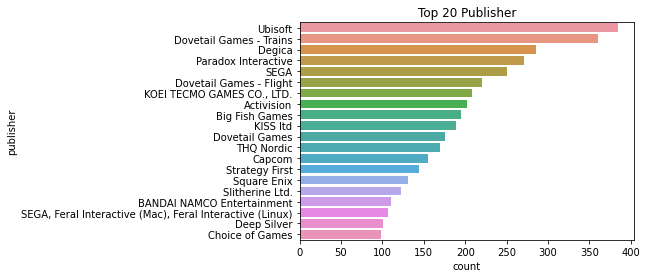

In [ ]:
def grafico_tops(data,by,columna,nombre,titulo,top=20):
  group_by_publisher=data.groupby(by=by)
  chart = sns.barplot(
      y=columna,
      x='count',
      data=pd.DataFrame(group_by_publisher[columna].count().rename(nombre)).reset_index().sort_values([nombre], ascending=False).head(top)
  )
  chart.set_title(titulo)
  plt.show()
grafico_tops(data=data_games,by=['publisher'],columna='publisher',nombre='count',titulo='Top 20 Publisher')

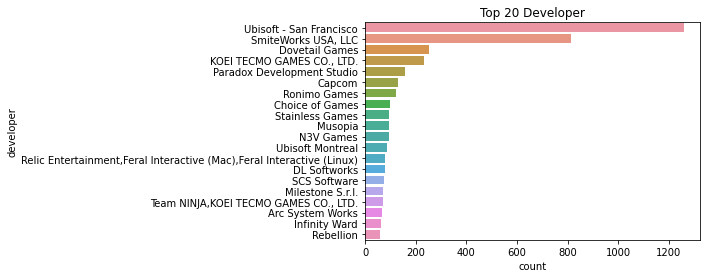

In [ ]:
grafico_tops(data=data_games,by=['developer'],columna='developer',nombre='count',titulo='Top 20 Developer')

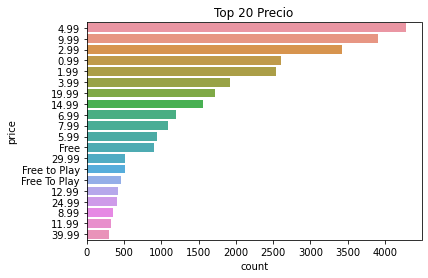

In [ ]:
grafico_tops(data=data_games,by=['price'],columna='price',nombre='count',titulo='Top 20 Precio')

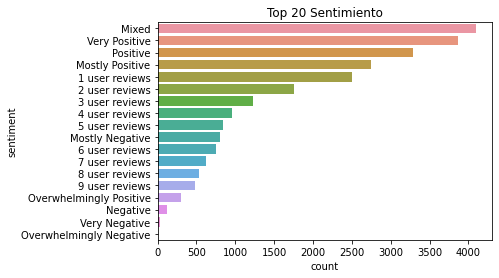

In [ ]:
grafico_tops(data=data_games,by=['sentiment'],columna='sentiment',nombre='count',titulo='Top 20 Sentimiento')

De aqui se desprende que no se le asigna sentimiento a productos con menos de 10 reseñas.

In [ ]:
data_games.sentiment.value_counts()

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2743
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     302
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64

In [ ]:
print('% de juegos sin sentimiento asignado')
data_games.sentiment.isna().sum()/data_games.shape[0]*100

% de juegos sin sentimiento asignado


22.348437694510146

Seran Juegos con 0 reseñas? Solo por curiosidad revisamos.

In [ ]:
print('Juegos sin "sentiment" encotrados en data_reviews')
len(pd.unique(data_games[data_games.sentiment.isna()].merge(data_reviews,right_on='product_id',left_on='id', how='inner').id))

Juegos sin "sentiment" encotrados en data_reviews


74

Bastante cerca, puede ser que los juegos con 'sentiment' == NaN no tengan reseñas y este pequeño descalce se deba a que primero se realizó el crawl del dataset de juegos y posterioremente el de reviews. 

Comparemos los datasets

In [ ]:
display(pd.DataFrame({
    'Productos en dataset Juegos': data_games.shape[0],
    'Productos reseñados': [len(pd.unique(data_reviews.product_id))]
}).transpose())
pd.DataFrame({
  'Reseñas totales': [data_reviews.shape[0]],
  'Reseñas econtradas en data_games': [data_reviews.merge(data_games, how='inner', left_on='product_id', right_on='id').shape[0]]
}).transpose()

,0
Productos en dataset Juegos,32132
Productos reseñados,12665


,0
Reseñas totales,770094
Reseñas econtradas en data_games,770094


Todos los juegos reseñados se encuentran en el dataset de Juegos

In [ ]:
data_games[pd.to_numeric(data_games.id, errors='coerce').notnull()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN,NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews,NaN


### Estadisticos sobre Total de horas Jugadas

#### Estadisticos sobre Horas

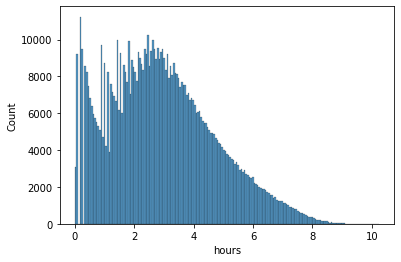

In [ ]:
chart = sns.histplot(np.log1p(data_reviews.hours))
# chart.set_xlim(0,500)
plt.show()

No encuentro explicación para esos picos. Quiza se deba a que los datos se recolectaron, en apariencia, en distintos crawls.

### Juegos Populares

In [ ]:
# product_sorted_by_count.product_id=product_sorted_by_count.product_id.astype(st)

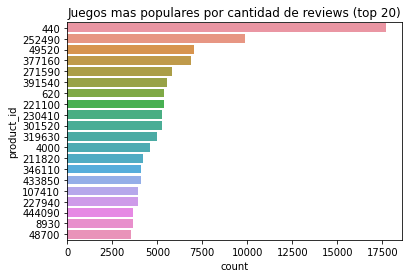

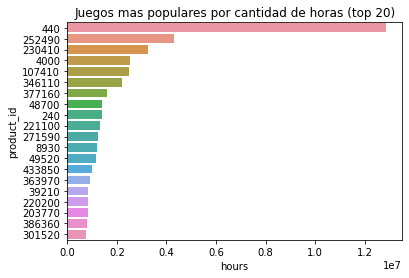

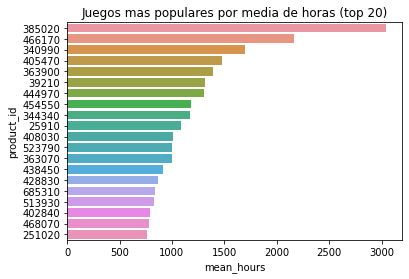

In [ ]:
group_by_productid=data_reviews.groupby(by=['product_id'])
# product_sorted_by_count.product_id=product_sorted_by_count.product_id.astype(str)
product_sorted_by_count=pd.DataFrame(group_by_productid.product_id.count().rename('count')).reset_index().sort_values(by=['count'], ascending=False)
product_sorted_by_hours=pd.DataFrame(group_by_productid.hours.sum().rename('hours')).reset_index().sort_values(by=['hours'], ascending=False)
product_sorted_by_meanhours=pd.DataFrame(group_by_productid.hours.mean().rename('mean_hours')).reset_index().sort_values(by=['mean_hours'], ascending=False)
chart = sns.barplot(x='count',y='product_id',data=product_sorted_by_count.head(20))
chart.set_title('Juegos mas populares por cantidad de reviews (top 20)')
plt.show()
chart = sns.barplot(x='hours',y='product_id',data=product_sorted_by_hours.head(20))
chart.set_title('Juegos mas populares por cantidad de horas (top 20)')
plt.show()
chart = sns.barplot(x='mean_hours',y='product_id',data=product_sorted_by_meanhours.head(20))
chart.set_title('Juegos mas populares por media de horas (top 20)')
plt.show()

In [ ]:
cantidad=20
tmp_popular=product_sorted_by_count.head(cantidad).merge(product_sorted_by_hours.head(cantidad), left_on='product_id', right_on='product_id',how='inner')
# tmp_popular=tmp_popular.head(cantidad).merge(product_sorted_by_meanhours.head(cantidad), left_on='product_id', right_on='product_id',how='inner')
print('Juegos que comparten el top 20 de horas totales y reviews totales: ',tmp_popular.shape[0])
tmp_popular=product_sorted_by_hours.head(cantidad).merge(product_sorted_by_meanhours.head(cantidad), left_on='product_id', right_on='product_id',how='inner')
print('Juegos que comparten el top 20 de horas totales y medaia de horasxreview: ',tmp_popular.shape[0])

Juegos que comparten el top 20 de horas totales y reviews totales:  14
Juegos que comparten el top 20 de horas totales y medaia de horasxreview:  1


In [ ]:
del(tmp_popular)
del(product_sorted_by_count)
del(product_sorted_by_hours)
del(product_sorted_by_meanhours)
del(product_total_hours)

Bueno, según la métrica que utilicemos, cambia el podio. Podriamos pensar que los que tiene más reviews coinciden con el top en ventas. (histórico)

## Valoración de las reseñas.

Vamos a intentar ponerle una puntuación a la reseña. Quizá sea necesario combinar, transformar, comparar o generar algunas variables.

### Page y page order.

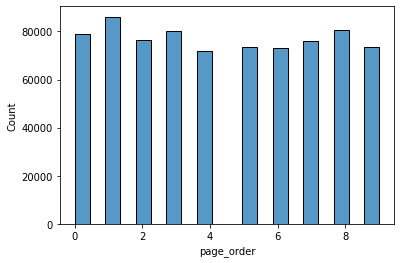

In [ ]:
sns.histplot(data_reviews.page_order, bins=20)
plt.show()

Interesante... Veamos si podemos entender esa distribución de esta variable investigando la pagina de steam.

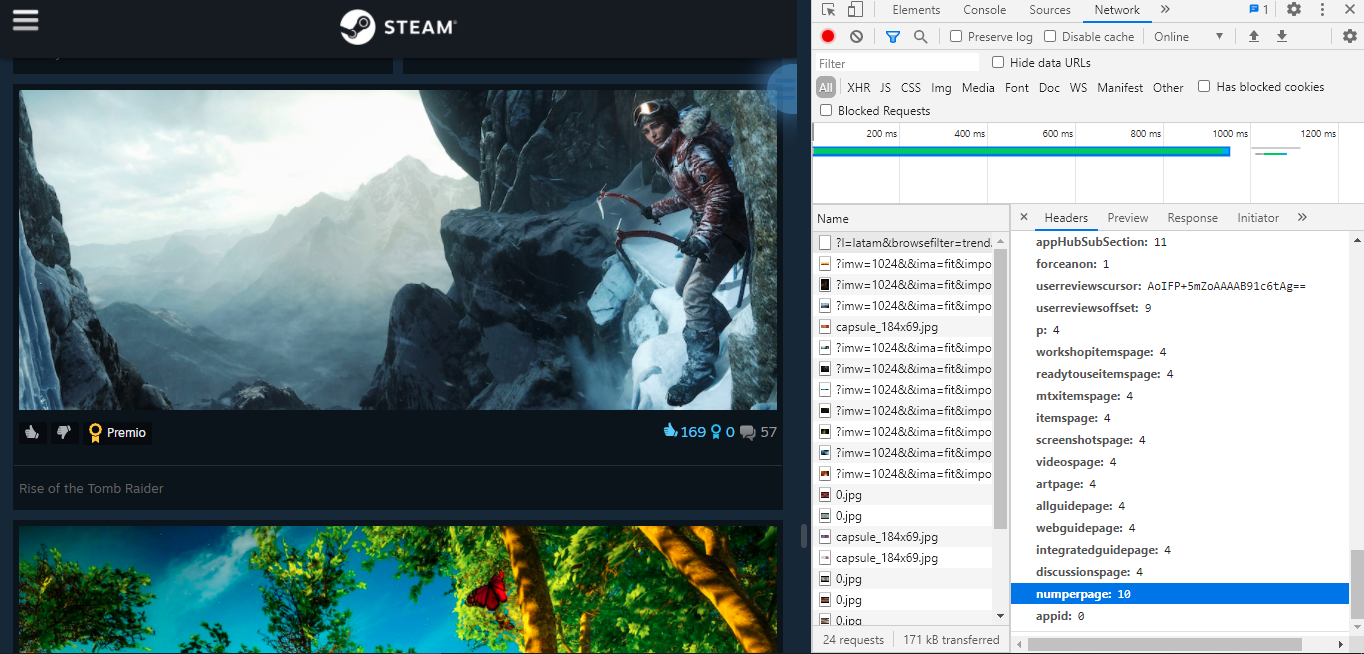

Lo web de steam, funciona con el método de load on scroll, por lo que podemos ver del los encabezados, carga 10 items/review por vez.
Tambien podemos ver que, por omisión, los revies estan ordenados por polularidad. Es decir que los items de determinada pagina (page) con page_oreder=0 son mas polupares que los que tienen page_order=9. Aunque no necesariamente indica que tan positiva o negativa es la review si indica que tan popular es esta review. Vamos a ver si es posible con estas dos columnas page y page_order determinar la calificación del juego.

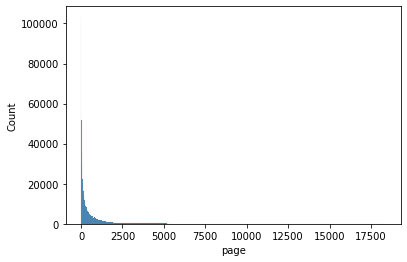

In [ ]:
chart = sns.histplot(data_reviews.page)
# chart.set_xlim(3000,4000)
# chart.set_ylim(0,500)

mmm... parece o pareciera que se hicieron varios crowls. El valor alcancado en count/10 para page=0 es la cantidad de veces que se arranco el crowl, se debe dividir por 10 por que es el numeo de de items por página. 
Tambien podemos ver que almenos uno de los crowl llegó a la pagina 17500.

Es una teoría. Vamos a seguir esta línea a ver si la podemos comprobar.

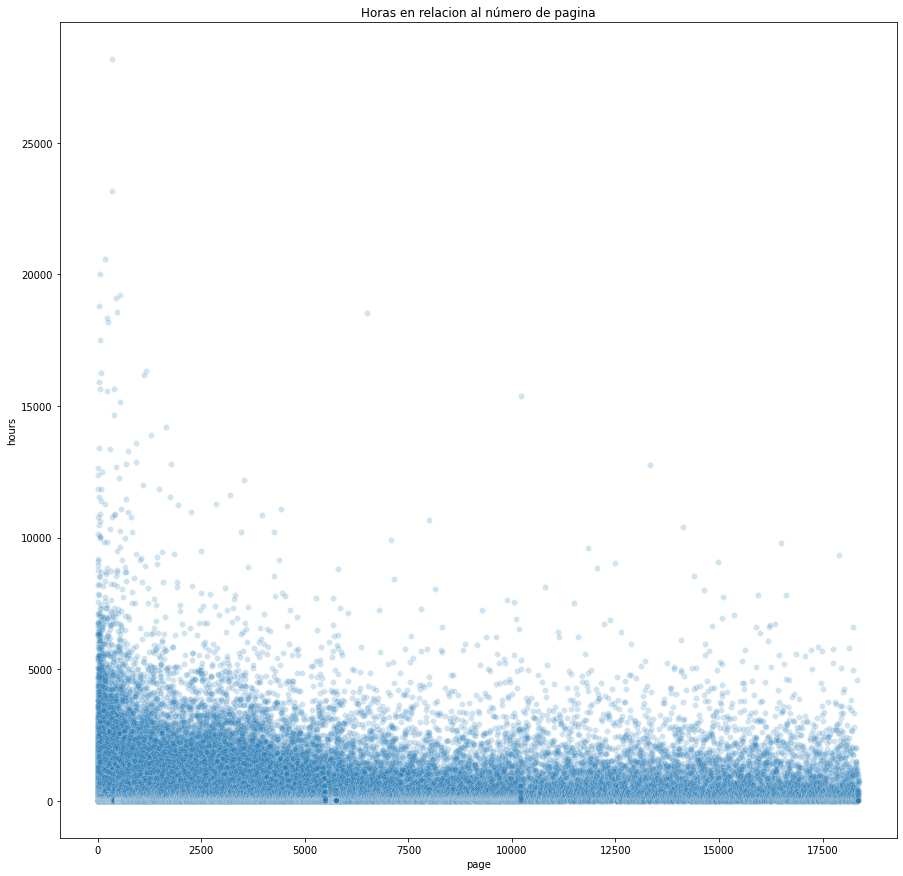

In [ ]:
plt.figure(figsize=(15,15))
chart = sns.scatterplot(x='page',y='hours', data=data_reviews, alpha=0.2)
chart.set_title('Horas en relacion al número de pagina')
plt.show()

Podemos apreciar que los juegos que aparecen en las primeras paginas se juegan mas horas que los deslas ultimas, pero la tendencia parece leve.

In [ ]:
data_reviews.sort_values(by=['page']).head(20)

,username,hours,products,product_id,page_order,date,text,early_access,page,compensation,found_funny
0,Chaos Syren_41.0,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,None,0.0
557947,Emperor LakeAhoi_243.0,0.7,243.0,318100,2,2017-12-29,"I'm sorry.\nI'm soory, I lied because of the s...",True,1,None,3.0
557958,ihatethenewenglandpatriots_105.0,2.7,105.0,498470,3,2017-09-21,What can be said? Simply an incredible experie...,False,1,None,0.0
557964,Lagreca_5550.0,2.7,5550.0,600250,2,2017-08-23,"Twenty years ago, I spent many remarkable afte...",True,1,Product received for free,0.0
557994,76561198409233863,0.1,41.0,381100,3,2017-11-26,This visual novel is really entertaining. Eve...,False,1,None,0.0
117851,Easy Target_2785.0,3.2,2785.0,723500,4,2017-11-08,Indie shooter with pixel graphics. dark atmosp...,False,1,None,0.0
558004,76561198145424372,0.8,137.0,351420,0,2017-11-16,May you prosper In all that you do. This game ...,False,1,None,0.0
117838,Ny'alotha_250.0,2.6,250.0,418610,8,2017-01-20,Yuri was easier! It's easier to beat Dark Soul...,False,1,Product received for free,0.0
117836,76561197988658544,1.8,39.0,418610,5,2017-05-13,I often like picking up some of these cheap pl...,False,1,None,0.0
558007,Minestra De Topher_272.0,0.2,272.0,351420,4,2017-01-12,Fun for the first 5 minutes. Poor control layo...,False,1,None,0.0


In [ ]:
data_reviews.sort_values(by=['page']).tail(20)

,username,hours,products,product_id,page_order,date,text,early_access,page,compensation,found_funny
396820,76561198130773584,1000.4,71.0,440,3,2014-08-28,BEST FREE TO PLAY GAME IN THE WORLDDDDDDDDDDDD...,False,18349,None,0.0
396821,76561198032125721,364.7,38.0,440,3,2014-08-27,"Greatest F2P game, ever.",False,18350,None,0.0
396822,76561198142303174,169.3,NaN,440,3,2014-08-28,you need to play this game becase its freaking...,False,18351,None,0.0
396824,76561198151838800,24.3,1.0,440,3,2014-08-28,YEESSSSSSSSSS GREAT GAME\nGATHER SOME FRIENDS ...,False,18353,None,0.0
396825,76561198079513742,208.9,67.0,440,3,2014-08-29,"Ever thought to yourself: ""I wish there was so...",False,18354,None,0.0
396826,Sukram_33.0,152.5,33.0,440,3,2014-08-27,very gud geim,False,18355,None,0.0
396827,b l u e s k y ._61.0,305.5,61.0,440,3,2014-08-28,"Very fun, lots of items and hats, fun gamemode...",False,18356,None,0.0
396828,ADrunkenDwarf_6.0,659.4,6.0,440,3,2014-08-28,It's good.,False,18357,None,0.0
396829,76561198151909079,232.2,30.0,440,4,2014-08-28,This is a great game,False,18358,None,1.0
396830,76561198136661980,750.6,14.0,440,4,2014-08-28,buy it if you want to be absorbed into the gre...,False,18359,None,1.0


Fue imposible econtrar una relación entre el orden de la página y la valoración de la reseña.

Veamos los productos.

In [ ]:
group_by_productid=data_reviews.groupby(by=['product_id'])
data_reviews['product_total_reviews']=group_by_productid.product_id.transform('count')

(0.0, 300.0)

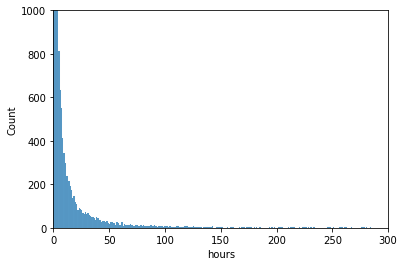

In [ ]:
chart = sns.histplot(group_by_productid.hours.mean())
chart.set_ylim(0,1000)
chart.set_xlim(0,300)


(0.0, 300.0)

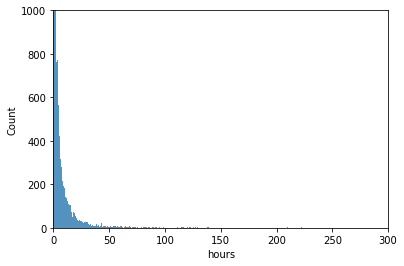

In [ ]:
chart = sns.histplot(group_by_productid.hours.median())
chart.set_ylim(0,1000)
chart.set_xlim(0,300)

### Horas Jugadas

La cantidad de horas delante de determinado juego podría indicar que tanto le gusta al usuario. Sin embargo existen algunos detalles a tener en cuenta.

* duración del juego: algunos juegos tienen principio y fin, otros como los online o el sudoku no lo tienen. Por esto no podemos indicar si un usuario que reseño dos juegos prefiere uno sobre el otro por la cantidad de horas jugadas.

* hours: no sabemos si hours representa las horas jugadas al momento de la reseña o las horas jugadas en total. Podría ser que un usuario hiciera la reseña temprano después de la compra o después de mucho tiempo. Por esto no podemos decir por las horas jugadas de dos usuarios a un juego a cual le gusto mas.

* fecha de adquisición: dos usuarios que reseñaron un mismo juego, llevan distinto tiempo jugándolo, por más que ambos jueguen la misma cantidad de horas diarias, el usuario que adquirió primero el juego tiene más horas acumuladas.Igual que con hours. Por esto no podemos decir por las horas jugadas de dos usuarios a un juego a cual le gusto mas.

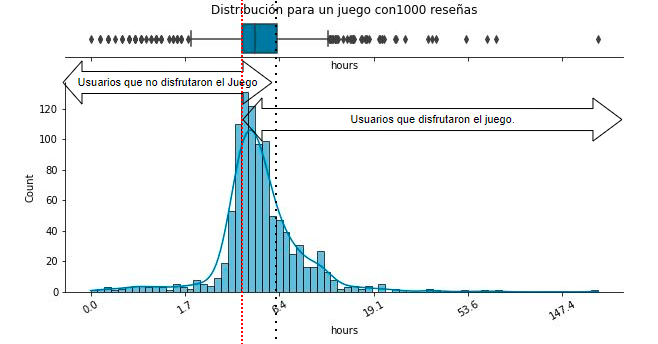

Arriba vemos la distribución de un juego cualquiera, con 1000 reseñas. 
Olvidemos por un momento si recomendaron o no recomendaron el juego o si la reseña tiene un sentimiento positivo o negativo. Concentrémonos en las horas dedicadas.

Cualquiera sea el motivo, está claro que los usuarios que más jugaron son los que más se engancharon con el juego, y por el contrario cuanto más temprano fue el abandono menos se engancharon. Para decidir que tanto le gustó el juego a un usuario, compararemos la cantidad de horas jugadas por el usuario, respecto a su ubicación en alguno de los cuantiles y le asignaremos una calificación de 1 a 5 siendo 5 la máxima puntuación.

Separaremos la distribución en quintiles del 20% cada uno, es decir 20%,40%,60%,80%

* Puntaje 1: para las reviews que estén hasta el q20%,
* Puntaje 2: para los que estén entre el q20% y q40%
* Puntaje 3: para los que estén entre el q40% y q 60%
* Puntaje 4: para los que estén entre q60% y q80%
* Puntaje 5: para los que estén sobre el q80%

A los productos de menos de 10 reseñas le daremos una valoración igual a 2.



##### Genereamos nuestro dataset de reviews, ahora solo con nuestras variables de interess.

In [ ]:
data_reviews_new=data_reviews[['username','hours','product_id','date']]
total_reviews=pd.DataFrame(data_reviews_new.product_id.value_counts().rename('product_total_reviews'))
total_reviews
data_reviews_new=data_reviews_new.merge(total_reviews, left_on='product_id', right_index=True)
# product_median_hours=pd.DataFrame(data_reviews_new.groupby(by=['product_id']).hours.mean().rename('product_median_hours'))
# data_reviews_new=data_reviews_new.merge(product_median_hours, left_on='product_id', right_index=True)

Cambianos algunos tipos de datos

In [ ]:
data_reviews_new.product_id=data_reviews_new.product_id.astype(int)
data_reviews_new.date= pd.to_datetime(data_reviews_new.date)
data_games.id=data_games.id.astype(int)

In [ ]:
# data_reviews_new
# data_games.info()

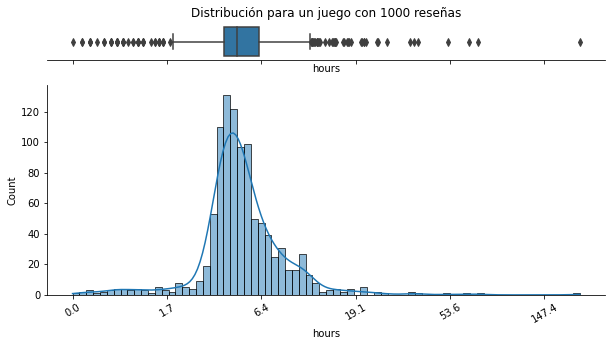

mean: 5.024685787996462


In [ ]:
pid=399660 # 15
# pid=318 # 10
pid=206440 # 1000
# pid=440
def estadisticas_producto(pid,figs=(10,5)):
  import warnings
  warnings.filterwarnings("ignore")
  horas=np.log1p(data_reviews[data_reviews['product_id']==str(pid)].hours)
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=figs,
                                      gridspec_kw={"height_ratios": (.15, .85)})
  ax_box.set_title('Distribución para un juego con '+str(len(horas))+' reseñas')

  sns.boxplot(horas, ax=ax_box)
  sns.histplot(horas,kde=True, ax=ax_hist)
  ax_box.set(yticks=[])
  # labels = ax_hist.get_xticklabels()
  # labels = [item.get_text() for item in ax_hist.get_xticklabels()]
  labels=np.round(np.exp(ax_hist.get_xticks())-1,1)
  ax_hist.set_xticklabels(labels, rotation=30) # set new labels
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)
  plt.show()
  # print('mean:',horas.mean())
  # print('median:',horas.median())
  # print('q25:',horas.quantile(.25))
  # print('q75:',horas.quantile(.75))
  # horas=np.exp(horas)-1
  print('mean:',np.exp(horas.mean()) -1 )
  # print('median:',horas.median())
  # print('q25:',horas.quantile(.25))
  # print('q75:',horas.quantile(.75))
  # return labels
estadisticas_producto(pid)

In [ ]:
# print('Distribucion en base a cantidad de reseñas')
# cantidad_de_reviews=[10,30,50,100]
# for cr in cantidad_de_reviews:
#   pids=pd.unique(data_reviews_new[data_reviews_new.product_total_reviews == cr]['product_id'])[0:3]
#   for pid in pids:
#     print(pid)
#     estadisticas_producto(pid,(5,3))  

Seteamos el valor

In [ ]:
group_by_username=data_reviews_new.groupby(by=['username'])
group_by_productid=data_reviews_new.groupby(by=['product_id'])
for q in [20,40,60,80]:
  q=group_by_productid.hours.quantile(q/100).rename('product_q'+str(q))
  data_reviews_new=data_reviews_new.merge(q,left_on='product_id',right_on='product_id')
  display(q.head(1))
# q20 = group_by_productid.hours.quantile(0.20).rename('product_q20')
# q40 = group_by_productid.hours.quantile(0.40).rename('product_q40')
# q60 = group_by_productid.hours.quantile(0.60).rename('product_q60')
# q80 = group_by_productid.hours.quantile(0.80).rename('product_q40')

# data_reviews_new=data_reviews_new.merge(median, left_on='product_id',right_on='product_id',)
# data_reviews_new=data_reviews_new.merge(q40, left_on='product_id',right_on='product_id',)
# data_reviews_new=data_reviews_new.merge(q60, left_on='product_id',right_on='product_id',)
# data_reviews_new=data_reviews_new.merge(IQR, left_on='product_id',right_on='product_id',)
# print(data_reviews_new[data_reviews_new.product_id=='10'].shape)

product_id
10    1.28
Name: product_q20, dtype: float64

product_id
10    5.3
Name: product_q40, dtype: float64

product_id
10    18.04
Name: product_q60, dtype: float64

product_id
10    54.62
Name: product_q80, dtype: float64

In [ ]:
data_reviews_new[data_reviews_new.product_id==313810]

,username,hours,product_id,date,product_total_reviews,product_q20,product_q40,product_q60,product_q80
8631,Budzik_16.0,10.8,313810,2017-07-26,10,4.26,7.64,11.08,16.6
8632,Lowlander2_265.0,4.1,313810,2017-02-02,10,4.26,7.64,11.08,16.6
8633,thearmadilloking_18.0,11.5,313810,2017-01-02,10,4.26,7.64,11.08,16.6
8634,76561197973832609,25.8,313810,2016-08-09,10,4.26,7.64,11.08,16.6
8635,][.nG.][ Ngelo Querro_1083.0,14.3,313810,2016-06-19,10,4.26,7.64,11.08,16.6
8636,76561198055037410,4.3,313810,2016-04-28,10,4.26,7.64,11.08,16.6
8637,RAVEN & STARFIRE_175.0,7.4,313810,2016-04-21,10,4.26,7.64,11.08,16.6
8638,MrTakis_106.0,31.1,313810,2016-04-17,10,4.26,7.64,11.08,16.6
8639,76561197965916889,7.8,313810,2016-01-24,10,4.26,7.64,11.08,16.6
8640,melonbeton_2073.0,2.9,313810,2015-09-19,10,4.26,7.64,11.08,16.6


In [ ]:
data_reviews_new['rating']=-1
mask=(data_reviews_new.hours <= data_reviews_new.product_q20) # horas = o por debajo de q20%
data_reviews_new.loc[mask,'rating']=1

mask=((
      data_reviews_new.hours > data_reviews_new.product_q20 # hours mayor a q40
    ) & (
      data_reviews_new.hours < data_reviews_new.product_q40 # hours menor q q60
    )
)

data_reviews_new.loc[mask,'rating']=2

mask=((
      data_reviews_new.hours >= data_reviews_new.product_q40 # hours mayor a q40
    ) & (
      data_reviews_new.hours <= data_reviews_new.product_q60 # hours menor q q60
    )
)

data_reviews_new.loc[mask,'rating']=3

mask=((
      data_reviews_new.hours > data_reviews_new.product_q60 # hours mayor a q40
    ) & (
      data_reviews_new.hours < data_reviews_new.product_q80 # hours menor q q60
    )
)


data_reviews_new.loc[mask,'rating']=4

mask=(data_reviews_new.hours >= data_reviews_new.product_q80) # horas = o por debajo de q20%
data_reviews_new.loc[mask,'rating']=5
display(mask.sum())
mask=(data_reviews_new.product_total_reviews < 10) # items menos de 10 reviews
data_reviews_new.loc[mask,'rating']=2

162159

In [ ]:
data_reviews_new[data_reviews_new.rating==-1]

,username,hours,product_id,date,product_total_reviews,product_q20,product_q40,product_q60,product_q80,rating


In [ ]:
# # SETEO VALORACIONES
# mask=(data_reviews_new.hours <= data_reviews_new.product_q40) # horas = o por debajo de q40%
# data_reviews_new.loc[mask,'rating']=1

# mask=((
#       data_reviews_new.hours > data_reviews_new.product_q40 # hours mayor a q40
#     ) & (
#       data_reviews_new.hours < data_reviews_new.product_q60 # hours menor q q60
#     )
# ).copy() # dentro de nuedtro falso IQR
# data_reviews_new.loc[mask,'rating']=2

# mask=(data_reviews_new.hours >= data_reviews_new.product_q60) # horas = por arriba de q60%
# data_reviews_new.loc[mask,'rating']=3

# mask=(data_reviews_new.hours >= data_reviews_new.product_median+data_reviews_new.IQR*1.5 ) # horas = por arriba de q60%
# data_reviews_new.loc[mask,'rating']=4

# mask=(data_reviews_new.product_total_reviews < 10) # items menos de 10 reviews
# data_reviews_new.loc[mask,'rating']=2

# # mask=(data_reviews_new.product_total_reviews < data_reviews_new.product_median-data_reviews_new.IQR*1.5) # items menos de 10 reviews
# # data_reviews_new.loc[mask,'rating']=0

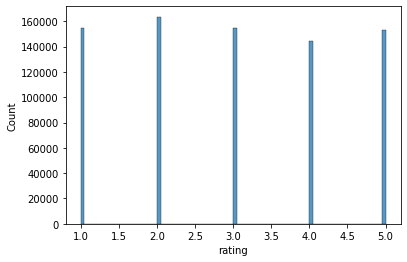

In [ ]:
sns.histplot(data_reviews_new.rating)

Esta distribución tan pareja se debe a que asignamos el rating basado en cuantiles.

In [ ]:
# liebero memoria
for todel in [group_by_username,group_by_productid,mask]:
  del(todel)

### Conclusión

Para que este modelo deberíamos ser capaces de determinar, cuánto le gusta el **producto A** al **usuario B** respecto a cuánto le gusta el **producto C** al **usuario B**, sin embargo estamos capturando, cuánto le gusta el **producto A** al **usuario B** respecto a cuánto le gusta el **producto A** al **usuario C**, aunque en este caso podria ser que a ninguno de los dos usuarios les halla gustado el **producto A**.

De todas formas, con este metodo podemo saber que un determinado usuario jugó el juego y que tanto le gusto con respecto al resto de los usuarios. 

Con el fin de poder continuar con el proyecto, utilizaremos este método de puntuación, pero en nada representa la realidad, algunas de las alternativas serían:

1. Volver a hacer el crawl de la dataset de reviews capturando la el valor "Recomended". De mínima esto sería suficiente.
2. Aplicar análisis de sentimiento sobre el comentario del review. Como alternativa a la primera opción aunque no sería suficiente o como complemento de la primera opción.
3. Saber cuando adquirió el producto.
4. Datos sobre la sesión, cuando lo uso y cuanto lo uso. De aquí se pueden saber si lo usa diariamente, semanalmente o si lo sigue jugando.

# Sistema de recomendación

In [ ]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 3.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670910 sha256=614845d892315547b08b2a9512d9233a7fcae9baf069d013ebefbf50f47f1a17
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD,SVDpp,SlopeOne,KNNBasic,NMF,KNNBaseline,BaselineOnly
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV
reader = Reader()

##Benchmark

Vamos a procesar el dataset con algunos de los algoritmos que ofrece la biblioteca surprise y ver si algunos de ellos se destaca sobre los demás.

In [ ]:
samples = 100000 # cantidad de muestras del dataset de reviews
data_review_small=data_reviews_new.sample(n=samples)
data = Dataset.load_from_df(data_review_small[['username', 'product_id','rating']], reader)

In [ ]:
fruits = ['apple', 'banana', 'cherry']

for i in range(len(fruits)):
  x = fruits.pop()
print(fruits)

[]


In [ ]:
%%time
algos = [SlopeOne(),SVD(),SVDpp(),NMF(),BaselineOnly()]
resultados=pd.DataFrame()
for algo in range(len(algos)):
  # algo=algos[i]
  algo=algos.pop()
  algo_name=algo.__class__.__name__
  print(algo_name)
  cv_result=cross_validate(algo, data,cv=3, measures=['rmse'], verbose = verbose )
  del(algo)
  print(cv_result)
  resultados=resultados.append({
      'Algo':algo_name,
      'RMSE':cv_result['test_rmse'].mean(),
      'RMSE std':cv_result['test_rmse'].std(),
      'fit_time':np.mean(cv_result['fit_time']),
      'test_time':np.mean(cv_result['test_time']),
      },
      ignore_index=True)
display(resultados.sort_values(by=['RMSE']))
display(algos)
gc.collect()

BaselineOnly
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4188  1.4179  1.4178  1.4182  0.0004  
Fit time          0.45    0.47    0.48    0.47    0.01    
Test time         0.21    0.20    0.20    0.20    0.00    
{'test_rmse': array([1.4187874 , 1.41787289, 1.41781857]), 'fit_time': (0.45386648178100586, 0.46785974502563477, 0.48020172119140625), 'test_time': (0.20755982398986816, 0.2024245262145996, 0.20297026634216309)}
NMF
Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4291  1.4364  1.4303  1.4320  0.0032  
Fit time          9.76    9.80    9.83    9.79    0.03    
Test time         0.41    0.23    0.22    0.29    0.09    
{'test_rmse': array([1.42913516, 1.43644034, 1.43032521]), 'fit_time': (9.761406421661377, 9.79549

,Algo,RMSE,RMSE std,fit_time,test_time
0,BaselineOnly,1.418160,0.000444,0.467309,0.204318
2,SVDpp,1.419953,0.000833,7.698997,0.313169
3,SVD,1.421154,0.003054,4.614243,0.223538
1,NMF,1.431967,0.003200,9.794552,0.289794
4,SlopeOne,1.435771,0.001125,1.661556,0.303276


[]

CPU times: user 1min 21s, sys: 661 ms, total: 1min 22s
Wall time: 1min 22s


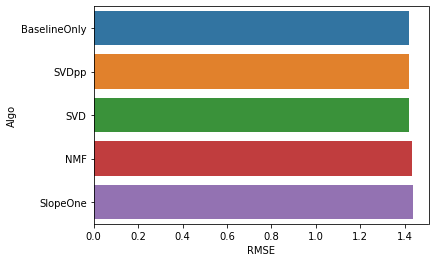

In [ ]:
sns.barplot(x='RMSE', y='Algo', data=resultados.sort_values(by=['RMSE']))

## Optimización de parámetros

Los resultados de los modelos seleccionados son similares, vamos a elegir el más popular SVD y su evolución SVDpp e intentar mejorar su desempeño. 

RMSE es una de las métricas de error que provee el modelo de evaluación de la biblioteca surprse, y buscamos minimizar este error.

### SVD

In [ ]:
%%time
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2], 'n_factors' : [5,50,100,150]}

gs_svd = GridSearchCV (SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1,joblib_verbose=3)

gs_svd.fit(data)

# best RMSE score
print(gs_svd.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_svd.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 19.1min


1.4111911810094107
{'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.2, 'n_factors': 50}
CPU times: user 18min 33s, sys: 10.4 s, total: 18min 43s
Wall time: 22min 45s


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 22.7min finished


### SVDpp

In [ ]:
%%time
param_grid = {'n_epochs': [5, 10, 20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2], 'n_factors' : [5,50,100,150]}

gs_svdpp = GridSearchCV (SVDpp, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1,joblib_verbose=3)

gs_svdpp.fit(data)

# best RMSE score
print(gs_svdpp.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_svdpp.best_params['rmse'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 36.7min


1.41120010291752
{'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.2, 'n_factors': 5}
CPU times: user 20min 6s, sys: 11.7 s, total: 20min 18s
Wall time: 45min 10s


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 45.2min finished


In [ ]:
pd.DataFrame({
    'Algo':['SVD','SVDpp'],
    'RMSE':[gs_svd.best_score['rmse'],gs_svdpp.best_score['rmse']]
})

,Algo,RMSE
0,SVD,1.411191
1,SVDpp,1.411200


El comportamiento fue muy similar, utilizaremos SVD que fue mucho mas rapido. Conseguimos reducir unas centesimas respecto al benchmar con los siguiente hiperparámetros.

In [ ]:
gs_svd.best_params['rmse']

{'lr_all': 0.001, 'n_epochs': 5, 'n_factors': 50, 'reg_all': 0.2}

# En Producción

La idea es crea las funciones y el pipelien para un sistema en producción, suponiendo que los dataset originales son las unicas entradas de nuestro sistema.

In [ ]:
# libero memoria
del(data_reviews)
del(data_reviews_grpbtusername)
del(data_reviews_new)
del(data_reviews_org)
del(group_by_productid)
del(group_by_username)
gc.collect()

93

## Funciones

### Carga de datase te dereviews

#### Funciones

In [ ]:
def load_reviews_from_gzip(file,n_lines=10):  
  """
  Carga el dataset en el formato dado, y genera un dataset solo con las columnas de interes
  
  Parameters
  ----------
  file: archivo 
  n_lines: cada cuantas lineas se genera el dataset
  """
  contador = 1
  data = []
  tmp_df=pd.DataFrame()
  data_reviews=pd.DataFrame()
  # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
  # abrira uno de cada tres, y asi.
  for l in parse(file):
    data.append(l)
    if contador%n_lines == 0:
      start = time()
      tmp_df=tmp_df.append(pd.DataFrame(data), ignore_index=True)
      tmp_df=tmp_df[['username','hours','products','product_id','date','user_id']]
      data_reviews=data_reviews.append(tmp_df, ignore_index=True)
      tmp_df=pd.DataFrame()
      # display(data_reviews)
      print('Lineas:'+str(contador)+' datalen: '+str(len(data)),end='')
      data=[]
      #print('time: '+str(int(time()-start)))
    contador += 1

  tmp_df=tmp_df.append(pd.DataFrame(data), ignore_index=True)
  tmp_df=tmp_df[['username','hours','products','product_id','date','user_id']]
  data_reviews=data_reviews.append(tmp_df, ignore_index=True)
  tmp_df=pd.DataFrame()
  # display(data_reviews)
  print('Lineas:'+str(contador)+' datalen: '+str(len(data)),end='')
  data=[]
  print('filas cargadas: '+str(data_reviews.shape[0]))
  return data_reviews

In [ ]:
def replace_usernamebyuser_id(data):
  """
  Cuando remplaza la variable username por user_id cuando user_id!=nan
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=(~data.user_id.isna())
  data.loc[mask,'username']=data[mask]['user_id']
  data['user_reset']=0;
  data.loc[mask,'user_reset']=1
  replaced=data[data.user_reset==1].shape[0]
  print('username remplazados:'+str(replaced)+' % del total:'+str(replaced/data.shape[0]*100))
  return data

In [ ]:
def drop_duplicate(data):
  """
  Dropea duplicados
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=data.duplicated(keep='first')
  duplicated=data[mask].shape[0]
  print('duplicados: '+str(duplicated)+' % del total:'+str(duplicated/data.shape[0]*100))
  return data[~mask]

In [ ]:
def clean_products_nan(data):
  """
  Elimina las filas que con user_id=nan y products=nan
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=((data.user_reset==0) & (data.products.isna()))
  nans=data[mask].shape[0]
  print('products=NaN: '+str(nans)+' % del total:'+str(round(nans/data.shape[0]*100,2)))
  return data[~mask]

In [ ]:
def concat_usernameWproducts(data):
  """
  Genera username univoco concatenando username+products cuando no exista user_id
  
  Parameters
  ----------
  data: dataframe de reviews
  """
  mask=mask=(data.user_reset==0)
  newusername=data.loc[mask,'username']+'_'+data.loc[mask,'products'].astype(str)
  data.loc[mask,'username']=newusername
  print('Usernam modificados: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))
  return data

In [ ]:
# data_reviews_2=data_reviews_2.drop(columns=['product_q20',	'product_q40'	,'product_q60',	'product_q80'])

In [ ]:
def rating_gen(data):
  """
  Genera ratings

  Parameters
  ----------
  data: dataframe de reviews
  """
  data['product_total_reviews']=data.groupby(['product_id']).product_id.transform('count')
  group_by_username=data.groupby(by=['username'])
  group_by_productid=data.groupby(by=['product_id'])
  for q in [20,40,60,80]:
    q=group_by_productid.hours.quantile(q/100).rename('product_q'+str(q))
    data=data.merge(q,left_on='product_id',right_on='product_id')
    display(q.head())
  print('data info')
  display(data.info())
  print('data isna')
  display(data.isna().sum())
  mask=(data.hours <= data.product_q20) # horas = o por debajo de q20%
  data.loc[mask,'rating']=1
  print('Reviews rating=1: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))
  mask=((
        data.hours > data.product_q20 # hours mayor a q40
      ) & (
        data.hours < data.product_q40 # hours menor q q60
      )
  )

  data.loc[mask,'rating']=2
  print('Reviews rating=2: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))
  mask=((
        data.hours >= data.product_q40 # hours mayor a q40
      ) & (
        data.hours <= data.product_q60 # hours menor q q60
      )
  )

  data.loc[mask,'rating']=3
  print('Reviews rating=3: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))

  mask=((
        data.hours > data.product_q60 # hours mayor a q40
      ) & (
        data.hours < data.product_q80 # hours menor q q60
      )
  )


  data.loc[mask,'rating']=4
  print('Reviews rating=4: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))

  mask=(data.hours >= data.product_q80) # horas = o por debajo de q20%
  data.loc[mask,'rating']=5
  print('Reviews rating=5: '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))
  mask=(data.product_total_reviews < 10) # items menos de 10 reviews
  data.loc[mask,'rating']=2
  print('Reviews rating=2 (menos de 10 reviews x producto): '+str(mask.sum())+' % del total:'+str(round(mask.sum()/data.shape[0]*100,2)))
  todrop=[]
  for q in [20,40,60,80]:
      todrop.append('product_q'+str(q))
  data.drop(columns=todrop, inplace=True)
  return data

### Pre procesamiento.

#### Variables

In [ ]:
data_reviews_full_clean=datapath+"data_reviews_full_clean.parquet"

#### Ejecución

In [ ]:
if os.path.isfile(data_reviews_full_clean):
  print ("Cargo dataset cache")
  data_reviews_2=pd.read_parquet(data_reviews_full_clean)
else:
  print('Salvo en cache')
  data_reviews_2=load_reviews_from_gzip(steam_reviews_file,n_lines=500000)
  data_reviews_2=replace_usernamebyuser_id(data_reviews_2)
  data_reviews_2=drop_duplicate(data_reviews_2)
  data_reviews_2=clean_products_nan(data_reviews_2)
  data_reviews_2=concat_usernameWproducts(data_reviews_2)
  data_reviews_2=rating_gen(data_reviews_2)
  data_reviews_2.drop(columns=['hours','products','user_id','user_reset','product_total_reviews'],inplace=True)
  data_reviews_2.to_parquet(data_reviews_full_clean)
data_reviews_2=data_reviews_2[~data_reviews_2.rating.isna()]
data_reviews_2.rating=data_reviews_2.rating.astype(int)
data_reviews_2.product_id=data_reviews_2.product_id.astype(int)

Cargo dataset cache


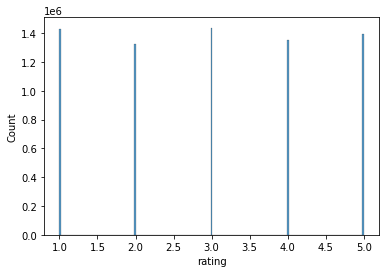

In [ ]:
sns.histplot(data_reviews_2.rating)

In [ ]:
data_reviews_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6931038 entries, 0 to 6956730
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   username    object
 1   product_id  int64 
 2   date        object
 3   rating      int64 
dtypes: int64(2), object(2)
memory usage: 264.4+ MB


Catalogo

In [ ]:
catalogo=data_games[['id','title']]

### Entrenamiento de filtro colaborativo

In [ ]:
data = Dataset.load_from_df(data_reviews_2[['username', 'product_id','rating']], reader)
svd=SVD(lr_all= 0.001, n_epochs= 5, n_factors= 5, reg_all= 0.002)

In [ ]:
%%time
trainset = data.build_full_trainset()

CPU times: user 19.5 s, sys: 826 ms, total: 20.3 s
Wall time: 20.3 s


In [ ]:
%%time
svd.fit(trainset)

CPU times: user 42.9 s, sys: 18.4 ms, total: 42.9 s
Wall time: 43 s


In [ ]:
svd.predict('76561197973832609',440)

Prediction(uid='76561197973832609', iid=440, r_ui=None, est=2.904276668628862, details={'was_impossible': False})

##### Recomendaciones

In [ ]:
# def recomienda_x_usename(username,data_reviews,data_games,rating=0,top=5,offset=0):
#   """
#   Recomienda peliculas

#   Parameters
#   ----------
#   username: username

#   data_reviews: dataset revisiones

#   data_games: dataset juegos

#   rating: el rating minimo que le tiene que haber otorgado a un titulo para la predicción

#   top: cuantas recomendaciones devuelve la recomendación

#   ofset: desplaza la recomendación descartando las primeras filas cantidad = offset
#   """
#   # data_user = data_reviews[data_reviews.username==username][['username','hours','product_id','rating']]
#   # seleccionas los reviews del usuario
#   data_user = data_reviews[data_reviews.username==username][['username','product_id','rating']]
#   data_user = data_user.reset_index(drop=True)

#   data_user=data_user.merge(data_games[['title','id']], right_on='id', left_on='product_id')
#   data_user=data_user.drop(columns=['id'])
#   recomedaciones=data_games[['id','title']]
#   # elimino los productos evaluados por el usuario
#   recomedaciones=recomedaciones[~recomedaciones.id.isin(data_user.product_id)]
#   data_user=data_user[data_user.rating >= rating]
#   if (data_user.shape[0]==0):
#     return False;
#   recomedaciones['est_rating']=recomedaciones['id'].apply(lambda x: svd.predict(username, x).est)
#   return recomedaciones.sort_values(by=['est_rating'],ascending=False).head(top+offset).tail(top).reset_index(drop=True)
# # recomienda_x_usename('Hanzo_531.0',data_reviews_2,data_games,rating=4)
# recomienda_x_usename('Hanzo',data_reviews_2,data_games,rating=4)

In [ ]:
def recomienda_x_usename(username,data_reviews,catalogo,rating=0,top=5,offset=0):
  """
  Recomienda peliculas

  Parameters
  ----------
  username: username

  data_reviews: dataset revisiones

  data_games: dataset juegos

  rating: el rating minimo que le tiene que haber otorgado a un titulo para la predicción

  top: cuantas recomendaciones devuelve la recomendación

  ofset: desplaza la recomendación descartando las primeras filas cantidad = offset
  """

  data_user = data_reviews[data_reviews.username==username][['username','product_id','rating']]
  data_user = data_user.reset_index(drop=True)
  recomedaciones=catalogo
  # elimino los productos evaluados por el usuario
  recomedaciones=recomedaciones[~recomedaciones.id.isin(data_user.product_id)]
  # descarto los productos del usuario segun scope 
  data_user=data_user[data_user.rating >= rating]
  if (data_user.shape[0]==0):
    return False;
  recomedaciones['est_rating']=recomedaciones['id'].apply(lambda x: svd.predict(username, x).est)
  return recomedaciones.sort_values(by=['est_rating'],ascending=False).head(top+offset).tail(top).reset_index(drop=True)


##### Verificación

Vemos las recomendaciones para un usuario cualquiera 

In [ ]:
np.random.seed(random_state)
data_reviews_2.sample(1).username.values[0]

'JoeMD_153.0'

In [ ]:
recomienda_x_usename(data_reviews_2.sample(1).username.values[0],data_reviews_2,catalogo,rating=1)

,id,title,est_rating
0,240,Counter-Strike: Source,3.979866
1,364450,Freshman Year,3.541940
2,353360,how do you Do It?,3.507186
3,504370,Battlerite,3.482306
4,620,Portal 2,3.474777


Ejecutamos dos iteraciones de 20 usuarios, distintos en cada ejecución y veamos el universo de títulos para cada conjunto de recomendaciones.
Recordemos que si el usuario no tiene títulos calificados con igual o mayor ranking, entonces no se le hará ninguna recomendación.

In [ ]:
def reco(n_usuarios=20,n_top=5,n_offset=0,rating=5,random_state=None):
  np.random.seed(random_state)
  tmp=pd.DataFrame()
  for item in data_reviews_2.sample(n_usuarios).username:
    print(item,' ',end='')
    rec=recomienda_x_usename(item,data_reviews_2,catalogo,rating=rating,offset=n_offset)
    if isinstance(rec,pd.DataFrame):
      tmp=tmp.append(rec)
  print('Cantidad de usuarios evaluados: ',n_usuarios)
  print('Cantidad total de recomendaciones esperadas: ',n_usuarios*n_top)
  print('Cantidad total de recomendaciones recividas: ',tmp.shape[0])
  t_recomendadas=pd.DataFrame(pd.unique(tmp.title))
  print('Cantidad de pelicuas distintas: '+str(t_recomendadas.shape[0]))
  display(t_recomendadas)
  return tmp
tmp=reco()

76561198052511859  76561198189536003  76561198060658496  Foggy Dewhurst_152.0  76561198211485389  76561198102276107  not a girl_222.0  Trikmeister_29.0  MohddPlays ツ_57.0  76561198060772959  YuraConst_285.0  76561198383926057  76561197970629433  76561198022629692  triph4mm3r_1112.0  HurtyNoob_602.0  76561198158126889  Dudezilla_24.0  76561198435688840  JoK3rS_WilD_614_22.0  Cantidad de usuarios evaluados:  20
Cantidad total de recomendaciones esperadas:  100
Cantidad total de recomendaciones recividas:  75
Cantidad de pelicuas distintas: 8


,0
0,Counter-Strike: Source
1,Freshman Year
2,The Plan
3,Borderlands 2
4,Torchlight II
5,Battlerite
6,The Old Tree
7,how do you Do It?


Repetimos.

In [ ]:
tmp1=reco()

dessert punk_155.0  Zoolo_216.0  Plastermaster_135.0  76561197973368900  76561198036251159  HASHEX_58.0  AUTOMATIC_97.0  Doctor Space_193.0  Felius_320.0  76561198157664923  76561197962697606  76561197985737394  76561198353737043  Sun_230.0  Dorraz_218.0  76561198042967850  CtrlAltDefeat_341.0  76561198012410120  YøŠhï💕_7.0  Zeneth Princess_61.0  Cantidad de usuarios evaluados:  20
Cantidad total de recomendaciones esperadas:  100
Cantidad total de recomendaciones recividas:  50
Cantidad de pelicuas distintas: 9


,0
0,Counter-Strike: Source
1,Freshman Year
2,how do you Do It?
3,The Old Tree
4,The Plan
5,Battlerite
6,The Witcher 2: Assassins of Kings Enhanced Edi...
7,Torchlight II
8,Portal 2


Comparamos

In [ ]:
pd.DataFrame(
    pd.unique(tmp.title)
    ).join(
        pd.DataFrame(
          pd.unique(tmp1.title)
        ),
        rsuffix='1'
    )

,0,01
0,Counter-Strike: Source,Counter-Strike: Source
1,Freshman Year,Freshman Year
2,The Plan,how do you Do It?
3,Borderlands 2,The Old Tree
4,Torchlight II,The Plan
5,Battlerite,Battlerite
6,The Old Tree,The Witcher 2: Assassins of Kings Enhanced Edi...
7,how do you Do It?,Torchlight II


Podemos ver que hay una gran coincidencia, sobretodo en las filas superiores, y que a medida que nos alejamos de los primeros puestos, comienza a ser mas variado.

Repitamos la prueba, pero esta vez, con un offset de 10

In [ ]:
tmp=reco(n_offset=10)

76561198352487626  76561198170195857  OstracizedCrows_81.0  76561198217777909  KEBAB_142.0  Solid Wolf_12.0  76561198090197335  The Muffin Man_187.0  76561198116713745  76561198046163025  Excalibur_196.0  Andrea Jordan_61.0  76561198238023122  76561198106322514  John Mirra_1645.0  76561198014570246  The Great Papyrus_79.0  76561197992700778  King of archers_95.0  76561197987743391  Cantidad de usuarios evaluados:  20
Cantidad total de recomendaciones esperadas:  100
Cantidad total de recomendaciones recividas:  50
Cantidad de pelicuas distintas: 14


,0
0,Rock Paper Scissors Champion
1,Day of Defeat: Source
2,The Witcher 2: Assassins of Kings Enhanced Edi...
3,Tom Clancy's Rainbow Six® Siege
4,Portal 2
5,The Binding of Isaac
6,Chivalry: Medieval Warfare
7,Battlerite
8,ARK: Survival Evolved
9,Far Cry 3


In [ ]:
tmp1=reco(n_offset=10)

ac19189_960.0  🎉_1150.0  Xacrous_126.0  Hockquan_452.0  kragor_263.0  R.Fortes_259.0  dav0_322.0  みoƦƦoƦ ₣o父_1278.0  76561198035054806  76561197975247124  76561198071002586  James!*_230.0  The power saver_159.0  Yeish_155.0  Thelodious_113.0  Darkspawn_11.0  76561198132837224  DiLkZzY_23.0  ArcadianExile_349.0  The Queg_459.0  Cantidad de usuarios evaluados:  20
Cantidad total de recomendaciones esperadas:  100
Cantidad total de recomendaciones recividas:  65
Cantidad de pelicuas distintas: 14


,0
0,Tom Clancy's Rainbow Six® Siege
1,Rock Paper Scissors Champion
2,Chivalry: Medieval Warfare
3,9.03m
4,ARK: Survival Evolved
5,Torchlight II
6,The Witcher 2: Assassins of Kings Enhanced Edi...
7,Day of Defeat: Source
8,Portal 2
9,Borderlands 2


Comparemos

In [ ]:
pd.DataFrame(
    pd.unique(tmp.title)
    ).join(
        pd.DataFrame(
          pd.unique(tmp1.title)
        ),
        rsuffix='1'
    )

,0,01
0,Rock Paper Scissors Champion,Tom Clancy's Rainbow Six® Siege
1,Day of Defeat: Source,Rock Paper Scissors Champion
2,The Witcher 2: Assassins of Kings Enhanced Edi...,Chivalry: Medieval Warfare
3,Tom Clancy's Rainbow Six® Siege,9.03m
4,Portal 2,ARK: Survival Evolved
5,The Binding of Isaac,Torchlight II
6,Chivalry: Medieval Warfare,The Witcher 2: Assassins of Kings Enhanced Edi...
7,Battlerite,Day of Defeat: Source
8,ARK: Survival Evolved,Portal 2
9,Far Cry 3,Borderlands 2


Podemos ver que el espectro de títulos ofrecidos se amplía a medida que nos alejamos del top, sigue habiendo similitudes entres las recomendaciones, pero la oferta es más variopinta, tanto para los títulos como para el orden de la recomendación. No es una solución elegante, pero circunvala de cierta forma el sobreajuste del modelo, a costa quizá de no hacer las recomendaciones.

# Conclusiones finales

Errores forzados: como ya mencionamos, el dataset de reviews no tiene la información necesaria para asignar una calificación a cada review, sumado al hecho que los usuarios no estaban del todo identificados. Esto forzó a dedicar mucho tiempo a suplir estas falencias y  no poner tanto foco en el modelo y la aplicación.

Errores no forzados: Creo que el método seleccionado para generar el rating a cada review no fue el mejor. Deberíamos haber escalado de alguna forma 'hours' para poder utilizar esa variable de una mejor forma.Utilizar quantiles, parece no haber sido la mejor opción, media y desvío estándar puede haber funcionado mejor.

Mejoras:
Aplicar análisis de sentimiento a los reviews no es una mala opción, si bien no tenemos un conjunto etiquetado en el dataset de reviews, el dataset de games indica que tan negativas o positivas son las reseñas en general para cada producto, y podriamos comparar los resultados contra esa variable. Deberíamos quedarnos con las revisiones en inglés.

Quedó en el tintero implementar un sistema híbrido, recomendado items por su similitud entre ellos ya sea con filtro colaborativo o con los datos propios del dataset de games, donde se podía encontrar el género, el desarrollado y demás información.

Aplicar algunos filtros y orden
* Producto de pago o gratis.
* Ordenados por año de lanzamiento.
* Recomendaciones  de productos de determinado desarrollador.
* Incluso entrenar el modelos con el último año.



# Próximos Pasos

El dataset de games contiene entre otros datos, qué tan positivas o negativas son los reviews que recibió el producto hasta el momento, no aclara la proporción, pero la misma descripción indica la tendencia.

Cantidad de productos según  el sentimiento de los reviews recibidos.

El dataset de games contiene entre otros datos, qué tan positivas o negativas son los reviews que recibió el producto hasta el momento, no aclara la proporción, pero la misma descripción indica la tendencia.
Cantidad de productos según  el sentimiento de los reviews recibidos.

* Mixed 4103
* Very Positive 3868
* Positive 3281
* Mostly Positive 2743
* 1 user reviews 2496
* 2 user reviews 1756
* 3 user reviews 1231
* 4 user reviews 964
* 5 user reviews 846
* Mostly Negative 802
* 6 user reviews 756
* 7 user reviews 619
* 8 user reviews 537
* 9 user reviews 488
* Overwhelmingly Positive 302
* Negative 123
* Very Negative 29
* Overwhelmingly Negative 7

La idea es trabajar, en principio, solo con aquellas reviews del data_reviews, de los productos que tengan este tipo de sentimiento.
* Overwhelmingly Positive 302   
* Very Positive 3868 
* Positive 3281 Mostly 
* Positive 2743  

Si bien no tendremos la certeza, podemos trabajar sobre la hipótesis que la mayoría de los reviews remanentes en data_reviews despues del filtrado, tendrán reviews con sentimiento que irá de positivo a muy positivo. Es decir sólo reviews positivas. 

Sobre este supuesto podremos crear una matriz de utilidad con una calificación igual a 1 para todas las entradas, y correr sobre la misma los algoritmos que nos facilita surprise, evitando así trabajar sobre una calificación basada en horas, que como hemos comentado, no representa el gusto del usuario sobre el producto.











-------------------------------

Verificación de efectividad

Surprise nos facilita algunas métricas de error, pero estas, solo sirven para determinar el error a la hora de imputar las celdas vacías de la matriz de utilidad, no nos facilita métodos para evaluar que tan buenas o efectivas han sido las recomendaciones.

La idea es entrenar al modelo con todas las entradas menos las del último año. Es decir, el dataset de **train** comprenderá desde la fila con la fecha más antigua, hasta la mayor - 365 días, y el dataset **testigo**, contendrán los últimos 365 días de reviews. 

Supongamos que el dataset de reviews comprende de 2012-01-01 a 2017-12-31, trabajaremos con los reviews de 2012-01-01 hasta 2016-12-31 como dataset de **train**, con este buscaremos el mejor algoritmo y los mejores parámetros (benchmark + GridsearchCV) y crearemos nuestro **modelo**.

Trataremos de analizar cuánto y quizá bajo qué condiciones, el **modelo** es efectivo. 

Procederemos de la siguiente forma.

> Tomaremos del dataset **testigo** aquellas entradas cuya tupla username,product_id, cumpla por lo menos con esta condición.
>
> 1.  El username tiene que haber hecho al menos una review en el dataset **train**.
>
>y
>
> 2.  el product_id tiene que haber tenido una revisión en en el dataset **train**

Con la tupla username, product_id de este subconjunto resultante, generamos recomendaciones en nuestro modelo, y veremos en qué posición del TOP de recomendación aparecen, intentando visualizar que tan acertado estuvo el modelo en sus predicciones en base al comportamiento futuro del usuario y si es posible, entender por qué acertó o falló.


Este notebook tambien se puede descargar de https://github.com/pelandrun/acamica/blob/main/proyecto_acamica_03v01.ipynb